In [1]:
import os
import sys
import pickle
import string
import string
import glob
import cv2

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.cluster import AgglomerativeClustering
from matplotlib.animation import FuncAnimation, MovieWriter
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from itertools import product
from matplotlib import ticker


import massPy as mp
from utils import *
from plot_utils import *
from AnalyseDefects_dev import AnalyseDefects
plt.style.use('sg_article')
plt.rcParams.update({"text.usetex": True,})


In [2]:

def extract_clp_results_single(clustering_dict, act_dir_list, save_path = None):
    """
    Analyse the defects for all the input folders
    """

    Nframes = clustering_dict['Nframes']
  
    # create arrays to store the clustering data
    cluster_arr = np.nan * np.zeros([Nframes, clustering_dict['Nwindows'], 3, clustering_dict['Nact'],])
    nn_arr = np.nan * np.zeros([Nframes, 2, clustering_dict['Nact']])

    for i, act_dir in enumerate(act_dir_list):
        print(i, act_dir)
        cl_res = np.load(os.path.join(act_dir, 'cl_arr.npy'))
        nn_res = np.load(os.path.join(act_dir, 'nn_arr.npy'))
        ff_idx = min(Nframes, cl_res.shape[0])
        cluster_arr[-ff_idx:, :cl_res.shape[1], :, i] = cl_res[-ff_idx:]
        nn_arr[-ff_idx:, :, i] = nn_res[-ff_idx:]

    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, f'clp_arr.npy'), cluster_arr)
        np.save(os.path.join(save_path, f'nn_arr.npy'), nn_arr)
    return cluster_arr

def extract_op_results(Nframes, act_dir_list, LX, calc_sem = False, save_path = None):
    """
    Analyse the defects for all the input folders
    """

    order_param_arr = np.nan * np.zeros([Nframes, 4, len(act_dir_list)])
    normalizer = np.sqrt(LX ** 2) if calc_sem else 1

    for i, act_dir in enumerate(act_dir_list):
        print(i, act_dir)

        op_res = np.load(os.path.join(act_dir, 'order_param_arr.npy'))
        ff_idx = min(Nframes, op_res.shape[0])

        order_param_arr[-ff_idx:, :, i] = op_res[-ff_idx:]
        order_param_arr[-ff_idx:, 1, i] /= normalizer
        order_param_arr[-ff_idx:, 3, i] /= normalizer

    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, f'order_param_arr.npy'), order_param_arr)
    return order_param_arr

def extract_dc_results(Nframes, act_dir_list, save_path = None):
    """
    Analyse the defects for all the input folders
    """

    for i, act_dir in enumerate(act_dir_list):
        print(i, act_dir)

        if i == 0:
            rvals = np.load(os.path.join(act_dir, 'rdf_rad_arr.npy'))
            rdf_arr = np.nan * np.zeros([Nframes, len(rvals), len(act_dir_list)])

        rdf = np.load(os.path.join(act_dir, 'rdf_arr.npy'))
        ff_idx = min(Nframes, rdf.shape[0])

        rdf_arr[-ff_idx:, :, i] = rdf[-ff_idx:]

    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, f'rvals.npy'), rvals)
        np.save(os.path.join(save_path, f'rdf_arr.npy'), rdf_arr)
    return rdf_arr, rvals

def get_defect_arr_from_frame(defect_dict, return_charge = False):
    """
    Convert dictionary of defects to array of defect positions
    Parameters:
    -----------
    defect_dict : dict
        Dictionary of defects positions and charges
    return_charge : bool
        If True, return defect charges as well

    Returns:
    --------
    defect_positions : np.ndarray
        Array of defect positions
    defect_charges : np.ndarray
    """

    Ndefects = len(defect_dict)
    if Ndefects == 0:
        return None
    
    defect_positions = np.empty([Ndefects, 3 if return_charge else 2])

    for i, defect in enumerate(defect_dict):
        if return_charge:
            defect_positions[i,:] = *defect['pos'], defect['charge']
        else:
            defect_positions[i,:] = *defect['pos'],
    return defect_positions

def arg_func(arr, r_max_list, cutoff):
    if np.any(arr == cutoff):
        return r_max_list[np.argwhere(arr == cutoff)[0][0]]
    else:
        return -1
    
def arg_func_idx(arr, cutoff):
    if np.any(arr == cutoff):
        return np.argwhere(arr == cutoff)[0][0]
    else:
        return -1

def arg_func2(arr, cutoff):
    if np.any(arr == cutoff):
        return arr[np.argwhere(arr == cutoff)[0][0]]
    else:
        return -1
    
def get_defect_density(defect_list, area, return_charges=False, save_path = None,):
        """
        Get defect density for each frame in archive
        parameters:
            defect_list: list of lists of dictionaries holding defect charge and position for each frame 
            area: Area of system
            return_charges: if True, return list of densities of positive and negative defects
        returns:
            dens_defects: array of defect densities (Nframes, 3) if return_charges is True else (Nframes, 2)
        """

        if return_charges:
            # Initialize list of defect densities
            dens_pos_defects = []
            dens_neg_defects = []
            for defects in defect_list:
                # Get no. of defects
                nposdef = len([d for d in defects if d['charge'] == 0.5])
                nnegdef = len([d for d in defects if d['charge'] == -0.5])

                dens_pos_defects.append(nposdef / area)
                dens_neg_defects.append(nnegdef / area)

            if save_path is not None:
                np.savetxt(save_path + '_pos', dens_pos_defects)
                np.savetxt(save_path + '_neg', dens_neg_defects)
            return dens_pos_defects, dens_neg_defects
        else:
            dens_defects = []
            for defects in defect_list:
                # Get no. of defects
                ndef = len(defects)
                dens_defects.append(ndef / area)
            if save_path is not None:
                np.savetxt(save_path, dens_defects)
            return dens_defects

def find_conv_time(def_arr, act_list, out_path, fig_path, ninfo, LX, mode='fwd', plot_density = False, \
                   stationarity_dict = dict(interval_len = 20, Njump = 20, Nconverged = -100, max_sigma_dist = 1)):

    Nframes, Nact = def_arr.shape
    conv_list = np.zeros(Nact)

    ncols=3
    nrows = np.ceil(Nact / ncols).astype(int)
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols, figsize=(12, 3*nrows))
    ax = ax.flatten()


    for i, act in enumerate(act_list):

            normalizer = LX ** 2 if plot_density else 1
            vals = def_arr[:, i] / normalizer

            av = np.mean(vals)
        

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                x = est_stationarity(vals, **stationarity_dict)[0]

            conv_list[i] = x
            ax[i].plot(np.arange(0, Nframes * ninfo, ninfo), vals, '.',
                        alpha = .5, markersize=9, label = rf'$dQ$ = {act}')
        
            if x > 0:
                ax[i].axvline(x * ninfo, color='black', linestyle='--', alpha=0.5)
            ax[i].set_ylim([0, 2 * av])
            ax[i].legend()  
            ax[i].grid(True)


    fig.supxlabel('Time')
    fig.supylabel('Number of defects')


    np.save(os.path.join(out_path, 'conv_list.npy'), conv_list)
    fig.savefig(os.path.join(fig_path, f'num_defects_{mode}{LX}.png'))

    # close figure
    plt.close(fig)
    return

def calc_lmax_lperc(clp_arr, rmax_list, act_list, conv_list, save_path, uncertainty_multiplier = 1, nmin_frames = 20):
    

    lmax_av = np.nan * np.zeros((len(act_list), 2))
    lperc_av = np.nan * np.zeros((len(act_list), 2))

    arg_func1d = lambda arr: arg_func(arr, rmax_list, cutoff = 1)
    lmax_arr = np.apply_along_axis(arg_func1d, axis=1, arr=clp_arr[:, :, -1, :,])
    lperc_arr = np.apply_along_axis(arg_func1d, axis=1, arr=clp_arr[:, :, 0, :,])

    for i, _ in enumerate(act_list):
        ff_idx = int(conv_list[i])

        mask = (lmax_arr[ff_idx:, i,] > 0)
        nsamples = mask.sum()
        if nsamples > nmin_frames:
            arr_res = lmax_arr[ff_idx:, i,][mask]
            lmax_av[i,0] = np.nanmean(arr_res)
            lmax_av[i,1] = np.nanstd(arr_res, ddof = 1,) / np.sqrt(nsamples / uncertainty_multiplier)


        mask_perc = (lperc_arr[ff_idx:, i,] > 0)
        nsamples_perc = mask_perc.sum()
        if nsamples_perc  > nmin_frames:
            arr_res_perc = lperc_arr[ff_idx:, i,][mask_perc]
            lperc_av[i,0] = np.nanmean(arr_res_perc)
            lperc_av[i,1] = np.nanstd(arr_res_perc, ddof = 1,) / np.sqrt(nsamples_perc / uncertainty_multiplier)

    np.save(os.path.join(save_path, 'lmax_arr.npy'), lmax_arr)
    np.save(os.path.join(save_path, 'lperc_arr.npy'), lperc_arr)
    np.save(os.path.join(save_path, 'lmax_av.npy'), lmax_av)
    np.save(os.path.join(save_path, 'lperc_av.npy'), lperc_av)
    return

def calc_nn_avg(nn_arr, def_arr, act_list, conv_list, LX, \
                uncertainty_multiplier = 1, weighted=False, \
                normalize = True, nmin_samples = 20, 
                save_path = None):
    
    nn_av = np.nan * np.zeros((len(act_list), 2))

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for j in range(len(act_list)):
            ff_idx = int(conv_list[j])
            normalizer = LX / np.sqrt(def_arr[ff_idx:,j]) if normalize else 1
            
            if (nn_arr[:,0,j] > 0).sum() >=  nmin_samples:
                if weighted:
                    nn_av[j] = calc_weighted_mean_vec(nn_arr[ff_idx:,0,j] / normalizer, 
                                                                nn_arr[ff_idx:,1,j] / normalizer, replace_null_uncertainties=True)[:2]
                    nn_av[j,1] *= np.sqrt(uncertainty_multiplier)
                else:
                    nn_av[j,0] = np.nanmean(nn_arr[ff_idx:,0,j] / normalizer)
                    nn_av[j,1] = np.nanstd(nn_arr[ff_idx:,0,j] / normalizer, ddof = 1,) \
                        / np.sqrt(nn_arr[ff_idx:,0,j].size / uncertainty_multiplier)           
    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, 'nn_av.npy'), nn_av)
    return nn_av

def calc_dc_avg(rdf_arr, act_list, conv_list, \
                uncertainty_multiplier = 1, njump=5,
                save_path = None):
    

    
    rdf_arr_av = np.nan * np.zeros((len(act_list), 2, rdf_arr.shape[1]))
  
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for j in range(len(act_list)):
            ff_idx = int(conv_list[j] / njump)
            rdf_arr_res = rdf_arr[ff_idx:,:,j]
            #nan_mask = np.isnan(rdf_arr_res)
            #rdf_arr_res = rdf_arr_res[~nan_mask]

            rdf_arr_av[j,0,:] = np.nanmean(rdf_arr_res, axis=0)
            rdf_arr_av[j,1,:] = np.nanstd(rdf_arr_res, axis=0, ddof = 1,) \
                / np.sqrt(rdf_arr_res.size / uncertainty_multiplier)        
    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, 'rdf_arr_av.npy'), rdf_arr_av)
    return rdf_arr_av

def calc_order_param_avg(order_param_arr, act_list, conv_list, \
                uncertainty_multiplier = 1, weighted=False, \
                save_path = None):
    
    order_param_av = np.nan * np.zeros((len(act_list), 4))

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for j in range(len(act_list)):
            ff_idx = int(conv_list[j])
   
            if weighted:
                order_param_av[j, :2] = calc_weighted_mean_vec(order_param_arr[ff_idx:,0,j], 
                                                            order_param_arr[ff_idx:,1,j] * np.sqrt(uncertainty_multiplier))[:2]
                order_param_av[j, 2:] = calc_weighted_mean_vec(order_param_arr[ff_idx:,2,j], 
                                                            order_param_arr[ff_idx:,3,j] * np.sqrt(uncertainty_multiplier))[:2]
                order_param_av[j,1] *= np.sqrt(uncertainty_multiplier)
                order_param_av[j,3] *= np.sqrt(uncertainty_multiplier)
            else:
                order_param_av[j,0] = np.nanmean(order_param_arr[ff_idx:,0,j])
                order_param_av[j,1] = np.nanstd(order_param_arr[ff_idx:,0,j], ddof = 1,) \
                    / np.sqrt(order_param_arr[ff_idx:,0,j].size / uncertainty_multiplier)           
                order_param_av[j,2] = np.nanmean(order_param_arr[ff_idx:,2,j])
                order_param_av[j,3] = np.nanstd(order_param_arr[ff_idx:,2,j], ddof = 1,) \
                    / np.sqrt(order_param_arr[ff_idx:,2,j].size / uncertainty_multiplier)           
    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, 'order_param_av.npy'), order_param_av)
    return order_param_av
        
def plot_order_param(order_param_arr, act_list, Nframes, ninfo, \
                    act_idx_exclude_list = [], lambda_val=None, save_path=None, \
                    ylim = None, mode = 'wet', direction = 'fwd'):
    
    fig, ax = plt.subplots()

    direction = 'forward' if direction == 'fwd' else 'backward'

    for j in range(len(act_list)):
        if j in act_idx_exclude_list: continue

        xvals = np.arange(0, Nframes * ninfo, ninfo)
        ax.plot(xvals, order_param_arr[:,0,j], '.-', label  = f'{act_list[j]}', alpha = .5)
    ax.set_xlabel('Time step')
    ax.set_ylabel('Order parameter (S)')

    ax.legend(ncols=7, loc='upper right',fontsize=12)   
    ax.set_title(rf' $\lambda = ${lambda_val} ({direction})' if mode == 'wet' else rf'Dry ({direction})')
    if ylim is not None:
        ax.set_ylim(ylim)

    fig.tight_layout()  

    if save_path is not None:
        fig.savefig(save_path)
    return fig, ax

def plot_order_param_double(order_param_arr, act_list, idx_lower, Nframes, ninfo, \
                    act_idx_exclude_list = [], lambda_val=None, save_path=None, \
                    ylim_list = None, mode = 'wet', direction = 'fwd'):
    
    fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
    for j in range(len(act_list)):
        if j in act_idx_exclude_list: continue
        ff_idx = 0
        ax[0 if j<idx_lower else 1].plot(order_param_arr[:,0,j], label  = f'{act_list[j]}')
    fig.supxlabel('Time step')
    fig.supylabel('Order parameter (S)')
    fig.suptitle(rf' $\lambda = ${lambda_val} ({direction})' if mode == 'wet' else rf'Dry ({direction})')
    fig.tight_layout()

    for i, axx in enumerate(ax):
        axx.set_ylim([-.05, .25]) if ylim_list is None else axx.set_ylim(ylim_list[i])
        axx.legend(ncol=4, loc='upper right', fontsize=12)

    if save_path is not None:
        fig.savefig(save_path)
    return fig, ax


In [ ]:
LX = 256
mode = 'wet' 
save_figs = True
letter_subfigs = True

calc_order_param_sem = False
extract = False
extract_op, extract_dc = False, False
extract_def, find_conv = False, False
analyze= False

nmin_frames = 10 #if #mode == 'wet' else 5
uncertainty_multiplier = 20
weighted = True

if mode == 'wet':
    folder_name = 'diff_lambda_periodic'
    lambda_list = [0, 1] # [0.1, 0.5, 0.8]#1] #1]
    subdir_name = 'wet'
elif mode == 'dry':
    folder_name = 'dry_periodic_long'
    lambda_list = [1,]
    subdir_name = 'dry'
elif mode == 'ac':
    folder_name = 'ac_periodic'
    lambda_list = [0,1]
    subdir_name = 'wet'

out_path_all = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\{folder_name}\{mode}\\na{LX}'
defect_position_dir = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive'
#figpath_article = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\figs'
figpath_article='C:\\Users\\Simon Andersen\\Documents\\Uni\\PhD\\Research\\Defect Unbinding\\Figs'

for lambda_val in lambda_list:

    base_path_fwd = f'X:\\jayeeta\\{folder_name}\\{subdir_name}\\na{LX}\\{lambda_val}\\fwd'
    base_path_bck = f'X:\\jayeeta\\{folder_name}\\{subdir_name}\\na{LX}\\{lambda_val}\\bck'
    if extract_def:
        base_path_defects_fwd = f'X:\\jayeeta\\{folder_name}\\{subdir_name}\\na{LX}\\{lambda_val}\\defect_positions\\fwd'
        base_path_defects_bck = f'X:\\jayeeta\\{folder_name}\\{subdir_name}\\na{LX}\\{lambda_val}\\defect_positions\\bck'

   # base_path_defects_fwd = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\{folder_name}\\{mode}\\na{LX}\\{lambda_val}\\defect_positions\\fwd'
   # base_path_defects_bck = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\{folder_name}\\{mode}\\na{LX}\\{lambda_val}\\defect_positions\\bck'

    out_path_main = os.path.join(out_path_all, f'{lambda_val}') #if mode == 'wet' else out_path_all
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')
    fig_path = os.path.join(out_path_main, 'figs')

    if extract or extract_def or extract_op or extract_dc:
        if not os.path.isdir(fig_path):
            os.makedirs(fig_path)
        if not os.path.isdir(out_path_main):
            os.makedirs(out_path_main)
        if not os.path.isdir(out_path_fwd):
            os.makedirs(out_path_fwd)
        if not os.path.isdir(out_path_bck):
            os.makedirs(out_path_bck)

        print(f'Analyzing {mode} with lambda = {lambda_val}')
        t1 = time.perf_counter()    

        act_dirs_fwd = [os.path.join(base_path_fwd, x) for x in os.listdir(base_path_fwd)]
        act_dirs_bck = [os.path.join(base_path_bck, x) for x in os.listdir(base_path_bck)] 

        if extract_def:
            act_dirs_def_fwd = [os.path.join(base_path_defects_fwd, x) for x in os.listdir(base_path_defects_fwd)]
            act_dirs_def_bck = [os.path.join(base_path_defects_bck, x) for x in os.listdir(base_path_defects_bck)]

        act_fwd = [float(x.split('-')[-2]) for x in os.listdir(base_path_fwd)]
        act_bck = [float(x.split('-')[-2]) for x in os.listdir(base_path_bck)]

        # save activity list
        np.save(os.path.join(out_path_fwd, 'act_fwd.npy'), act_fwd)
        np.save(os.path.join(out_path_bck, 'act_bck.npy'), act_bck)
    else:
        act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
        act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))

    act_exclude_fwd = []
    act_exclude_bck = []

    Nact_fwd = len(act_fwd)
    Nact_bck = len(act_bck)
    Nact_list = [Nact_fwd, Nact_bck]

    rmax_list = np.arange(1, int(LX / np.sqrt(2))) 
    Nframes = 1000 #if mode=='wet' #else 50
    Nwindows = len(rmax_list)
    ninfo = 1000

    cluster_dict_fwd = dict(LX = LX, Nframes = Nframes, \
                        Nact = len(act_fwd), \
                        Nwindows = len(rmax_list), \
                        path = out_path_fwd, suffix = '_fwd')
    cluster_dict_bck = dict(LX = LX, Nframes = Nframes, \
                        Nact = len(act_bck), \
                        Nwindows = len(rmax_list), \
                        path = out_path_bck, suffix = '_bck')
    
    if extract_def:
            def_arr_fwd = np.zeros([Nframes, Nact_fwd])
            def_arr_bck = np.zeros([Nframes, Nact_bck])

            for i, (act_dir_list, arr) in enumerate(zip([act_dirs_def_fwd, act_dirs_def_bck], [def_arr_fwd, def_arr_bck])):
                print("Extracting defects for", 'fwd' if i == 0 else 'bck')
                for j, act_dir in enumerate(act_dir_list):
                    print(j)
                    path = os.path.join(act_dir, 'defect_positions.pkl')
                    with open(path, 'rb') as f:
                        defect_dict = pickle.load(f)
                    def_list_pos = get_defect_density(defect_dict, area = 1)
                    ff_idx = min(Nframes, len(def_list_pos))
                    arr[-ff_idx:, j] = def_list_pos[-ff_idx:]

            # save 
            np.save(os.path.join(out_path_fwd, 'def_arr.npy'), def_arr_fwd)
            np.save(os.path.join(out_path_bck, 'def_arr.npy'), def_arr_bck)
    if extract:
        clp_arr_fwd = extract_clp_results_single(cluster_dict_fwd, act_dirs_fwd, save_path=out_path_fwd)
        clp_arr_bck = extract_clp_results_single(cluster_dict_bck, act_dirs_bck, save_path=out_path_bck)
    else:
        clp_arr_fwd = np.load(os.path.join(out_path_fwd, 'clp_arr.npy'))
        clp_arr_bck = np.load(os.path.join(out_path_bck, 'clp_arr.npy'))
        def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))
        def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
        nn_arr_fwd = np.load(os.path.join(out_path_fwd, 'nn_arr.npy'))
        nn_arr_bck = np.load(os.path.join(out_path_bck, 'nn_arr.npy'))
    if extract_op:
        order_param_arr_fwd = extract_op_results(Nframes, act_dirs_fwd, LX, calc_sem=calc_order_param_sem, save_path=out_path_fwd)
        order_param_arr_bck = extract_op_results(Nframes, act_dirs_bck, LX, calc_sem=calc_order_param_sem, save_path=out_path_bck)
    else:
        try:
            order_param_arr_fwd = np.load(os.path.join(out_path_fwd, 'order_param_arr.npy'))
            order_param_arr_bck = np.load(os.path.join(out_path_bck, 'order_param_arr.npy'))
        except:
            pass
    if extract_dc:
        rdf_arr_fwd, rvals_fwd = extract_dc_results(Nframes, act_dirs_fwd, save_path=out_path_fwd)
        rdf_arr_bck, rvals_bck = extract_dc_results(Nframes, act_dirs_bck, save_path=out_path_bck)
    else:
        try:
            rdf_arr_fwd = np.load(os.path.join(out_path_fwd, 'rdf_arr.npy'))
            rdf_arr_bck = np.load(os.path.join(out_path_bck, 'rdf_arr.npy'))
            rvals_fwd = np.load(os.path.join(out_path_fwd, 'rvals.npy'))
            rvals_bck = np.load(os.path.join(out_path_bck, 'rvals.npy'))
        except:
            pass
    if not find_conv:
        try:
            conv_list_fwd = np.load(os.path.join(out_path_fwd, 'conv_list.npy'))
            conv_list_bck = np.load(os.path.join(out_path_bck, 'conv_list.npy'))
        except:
            conv_list_bck = np.zeros(Nact_bck)
            conv_list_fwd = np.zeros(Nact_fwd)
    else:
        block_size = 20 #if mode=='wet' else 5
        Nconverged = 5*block_size
        find_conv_time(def_arr_fwd, act_fwd, out_path_fwd, fig_path, ninfo, LX, mode='fwd', plot_density = False, \
                stationarity_dict = dict(interval_len = block_size, Njump = block_size, Nconverged = Nconverged, max_sigma_dist = 1))
        find_conv_time(def_arr_bck, act_bck, out_path_bck, fig_path, ninfo, LX, mode='bck', plot_density = False, \
                stationarity_dict = dict(interval_len = block_size, Njump = block_size, Nconverged = Nconverged, max_sigma_dist = 1))
    if analyze:
        print(f'Analyzing {mode} lambda=', lambda_val) 
        
        njump_between_frames = 5
        calc_lmax_lperc(clp_arr_fwd, rmax_list, act_fwd, conv_list_fwd, out_path_fwd, \
                        uncertainty_multiplier = uncertainty_multiplier/5 if Nframes<100 else uncertainty_multiplier, \
                            nmin_frames = nmin_frames)
        calc_lmax_lperc(clp_arr_bck, rmax_list, act_bck, conv_list_bck, out_path_bck, \
                        uncertainty_multiplier = uncertainty_multiplier/5 if Nframes<100 else uncertainty_multiplier, \
                            nmin_frames = nmin_frames)
        calc_nn_avg(nn_arr_fwd, def_arr_fwd, act_fwd, conv_list_fwd, LX, \
                uncertainty_multiplier = uncertainty_multiplier, weighted=weighted, normalize = True, nmin_samples = nmin_frames, 
                save_path = out_path_fwd)
        calc_nn_avg(nn_arr_bck, def_arr_bck, act_bck, conv_list_bck, LX, \
                uncertainty_multiplier = uncertainty_multiplier, weighted=weighted, normalize = True, nmin_samples = nmin_frames, 
                save_path = out_path_bck)
        order_param_fwd_av = calc_order_param_avg(order_param_arr_fwd, act_fwd, conv_list_fwd, \
                uncertainty_multiplier = uncertainty_multiplier, weighted=True, save_path = out_path_fwd)
        order_param_bck_av = calc_order_param_avg(order_param_arr_bck, act_bck, conv_list_bck, \
                uncertainty_multiplier = uncertainty_multiplier, weighted=True, save_path = out_path_bck)
        try:
            rdf_arr_fwd_av = calc_dc_avg(rdf_arr_fwd, act_fwd, conv_list_fwd, njump=njump_between_frames, \
                            uncertainty_multiplier = uncertainty_multiplier, save_path = out_path_fwd)
            rdf_arr_bck_av = calc_dc_avg(rdf_arr_bck, act_bck, conv_list_bck, njump=njump_between_frames, \
                        uncertainty_multiplier = uncertainty_multiplier, save_path = out_path_bck)	
        except:
            print(r'No rdf data found for lambda = ', lambda_val)

Analyzing wet lambda= 0.1
Analyzing wet lambda= 0.5
Analyzing wet lambda= 0.8
No rdf data found for $\lambda = $ 0.8


In [ ]:
### Passive RNN plot for 0<lambda<1 ###

plt.rcParams.update({"text.usetex": True, "legend.fontsize": 14, 
                     "legend.handlelength": 0,
                     })

fig, ax = plt.subplots(ncols=3,figsize=(15, 4.))
ax = ax.flatten()
normalize=True
marker_list = ['dotted', 'dashed', 'dashdot']
ninfo = 1000

for i, lambda_val in enumerate([0.1, .5, .8]):
    mode = 'wet'
    normalizer = LX if normalize else 1
    out_path_main = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda_periodic\\{mode}\\na{LX}\\{lambda_val}'
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
    def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))

    nn_arr_fwd = np.load(os.path.join(out_path_fwd, 'nn_arr.npy'))
    nn_arr_bck = np.load(os.path.join(out_path_bck, 'nn_arr.npy'))
    nn_arr_av_fwd = np.load(os.path.join(out_path_fwd, 'nn_av.npy'))
    nn_arr_av_bck = np.load(os.path.join(out_path_bck, 'nn_av.npy'))


    ax[i].errorbar(act_fwd, nn_arr_av_fwd[:,0], yerr=nn_arr_av_fwd[:,1], alpha=.5,ms=8,fmt='b>-', label=r'Forward', lw=1, elinewidth=2)# if i==0 else None)#$\overline{l_{max}}$ (Forward)' if i==0 else None)# label=r'$\overline{l_{max}}$')
    ax[i].errorbar(act_bck, nn_arr_av_bck[:,0], yerr=nn_arr_av_bck[:,1], fmt='<-',color='darkorange', alpha=.7, ms=8,lw=1, elinewidth=2, label=r'Backward')#  if i==0 else None) # $~~~~~~~~~\hspace{5em}$' if i==0 else None)# label=r'$\overline{l_{perc}}$')

    ax[i].set_ylim([0, .9])#0.8))
    ax[i].set_xlim([-2.5e-3 if i==0 else -2.5e-4, max(act_fwd[-1], act_bck[-1]) + 2.5e-3 if i==0 \
                    else max(act_fwd[-1], act_bck[-1]) + 2.5e-4])

  #  ax[i].set_xlabel(r'Effective Temperature ($T^*$)',)# x=1.1)


  #  ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
  #  ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(0.01 if i==0 else 0.001))


    ax[i].hlines(0.5, -.12,.12, linestyle='--', color='black', alpha=0.5,)
    ax[i].legend(fontsize=14, loc='lower right',) # handlelength=1, ncol=1) #if i==0 else None)
    ax[i].text(0.07, 0.1, rf'$\lambda = ~${lambda_val}', transform=ax[i].transAxes, fontsize=22)
    
    if 0:
        ###############################################################################
        xticks = [0, 2e5, 4e5, 6e5, 8e5,10e5]
        xticks_labels = ['0', '2', '4', '6', '8', '10']
        ax[2+i].set_xticks(xticks, xticks_labels)
        ax[2+i].text(0.04, 0.13, rf'$\lambda = ~${lambda_val} (Backward)', transform=ax[2+i].transAxes, fontsize=22)
        ax[2+i].set_xlim([0, 1e6])
        ax[2+i].xaxis.set_minor_locator(ticker.MultipleLocator(1e5))
        ax[2+i].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

        for j, temp in enumerate(act_bck[:3]):
            mask_bck = nn_arr_bck[:,0, j] > 0
            normalizer = 1 # = LX / np.sqrt(def_arr_bck[mask_bck,j]) if normalize else 1
            xvals = np.arange(0, Nframes * ninfo, ninfo)[mask_bck]

            ax[2+i].plot(xvals, nn_arr_bck[mask_bck, 0, j] / normalizer, ls=marker_list[j], label = rf'$T^* = ${temp:.3f}')
            #ax[2+i].set_xlabel(r'Time step') # ($1/10^6$)')
            ax[2+i].set_ylim([0, .9])  

            ax[2+i].legend(ncols=3, loc='upper left',fontsize=14, handlelength=1)# if j==2 else 1)   

ax[0].set_ylabel(r'Av. NN-distance ($r_{nn}/r_{av}$)')
#ax[2].set_ylabel(r'NN-distance ($r_{nn}(t)/r_{av}(t)$)')
#fig.supxlabel(r'Time step ($10^5$)',x=.525,y=0.025)
fig.supxlabel(r'Effective Temperature ($T^*$)',x=.525,y=0.095)



for n, AXX in enumerate(ax):
    n0 = 0
    AXX.tick_params(axis='both',which='major', labelsize=14 if n==0 else 14)
    AXX.text(0.0 if n==0 else 0.0, 1.05, rf"{{\fontfamily{{ntxtlf}}\selectfont\textit{{({string.ascii_lowercase[n]})}}}}", transform=AXX.transAxes,
            size=20,  weight='normal',fontstyle='italic',fontfamily="Times New Roman", color = 'black' if letter_subfigs else 'white',)

fig.tight_layout()
save_path = os.path.join(out_path_all, 'figs')
if not os.path.isdir(save_path):
    os.makedirs(save_path)

if save_figs:
    fig.savefig(os.path.join(save_path, f'rnn_av_lambda_app.pdf'), dpi=720, bbox_inches='tight', pad_inches=.1)
    fig.savefig(os.path.join(figpath_article, f'rnn_av_lambda_app.pdf'), dpi=720, bbox_inches='tight', pad_inches=.1) 

In [ ]:
#### DIRECTOR CORRELATION PLOT ####


plt.rcParams.update({"text.usetex": True, "legend.fontsize": 14, 
                     "legend.handlelength": 0,
                     })

fig, ax = plt.subplots(ncols=2,figsize=(12, 4.5))
ax = ax.flatten()
normalize=True
marker_list = ['dotted', 'dashed', 'dashdot']
ninfo = 1000

for i, lambda_val in enumerate([0, 1]):
    mode = 'wet'
    normalizer = LX if normalize else 1
    out_path_main = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda_periodic\\{mode}\\na{LX}\\{lambda_val}'
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_include_list = [0.03, 0.045, 0.07] if lambda_val == 0 else [.003, 0.004, 0.01]
    act_idx_fwd_include_list = [3, -6, -2,]# -1]

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    rdf_arr_av_fwd = np.load(os.path.join(out_path_fwd, 'rdf_arr_av.npy'))
    rdf_arr_av_bck = np.load(os.path.join(out_path_bck, 'rdf_arr_av.npy'))
    rvals = np.load(os.path.join(out_path_fwd, 'rvals.npy'))


    act_bck = act_bck #[act_idx_bck_include_list]
    act_fwd = act_fwd #[act_idx_fwd_include_list]
    rdf_arr_av_fwd = rdf_arr_av_fwd #[act_idx_fwd_include_list]
    rdf_arr_av_bck = rdf_arr_av_bck #[act_idx_bck_include_list]

    if i == 0:
      
        rdf_arr30_av = np.load(os.path.join(out_path_fwd, 'rdf_arr_t003_av.npy'))[0,0,:]
        ax[i].plot(rvals/LX, rdf_arr30_av,'-', color=f'C{0}',  label = rf'$T^* = ${act_include_list[0]:.3f}')

    for j, act in enumerate(act_include_list):
        #act_idx_fwd = np.argwhere(act_fwd == act)[0][0]
        #act_idx_bck = np.argwhere(act_bck == act)[0][0]
        try:
            act_idx_fwd = np.argwhere(act_fwd == act)[0][0]
            ax[i].plot(rvals/LX, rdf_arr_av_fwd[act_idx_fwd, 0,:],'-', color=f'C{j}',  label = rf'$T^* = ${act:.3f}')
        except:
            pass
        try:
            act_idx_bck = np.argwhere(act_bck == act)[0][0]
            ax[i].plot(rvals/LX, rdf_arr_av_bck[act_idx_bck, 0,:],ls='dashed', color=f'C{j}',)# label = rf'$T^* = ${act:.3f}' if j==0 else None) # $~~~~~~~~~\hspace{5em}$' if i==0 else None)# label=r'$\overline{l_{perc}}$')
        except:
            pass

    ax[i].legend(fontsize=14, loc='upper right', handlelength=1, ncol=1) #if i==0 else None)
    ax[i].set_ylim([-0.1, 1])
    ax[i].set_xlim([-.01, .5])
    ax[i].hlines(0, 0, .5, color='black', lw=1, zorder=-1)
    ax[i].text(0.05, 0.85, rf'$\lambda = ~${lambda_val}', fontsize=22) # transform=ax[i].transAxes, fontsize=22)
    ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(5e-2))
ax[0].set_ylabel(r'Director correlation ($C_{\textbf{nn}} (r)$)')
fig.supxlabel(r'Radial distance ($r/L$)',x=.525,y=0.05)
#
# fig.suptitle(r'Solid: Forward ~~~~~~~~~~~~~~~~~~ Dashed: Backward', fontsize=18, x=.535,y=.935,)# bbox_to_anchor=(0.5, 1.02))#, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white')) 
fig.suptitle(r'Forward: $\textbf{---}$ ~~~~~~~~~~~~~~~~~~ Backward: $--$', fontsize=18, x=.535,y=.935,)
#ax[1].set_yscale('log')
for n, AXX in enumerate(ax):
    AXX.tick_params(axis='both',which='major', labelsize=14 if n==0 else 14)

fig.tight_layout()
save_path = os.path.join(out_path_all, 'figs')
if not os.path.isdir(save_path):
    os.makedirs(save_path)
if save_figs:
    fig.savefig(os.path.join(save_path, f'correlation.png'), bbox_inches='tight', dpi=520, pad_inches=.1)
    fig.savefig(os.path.join(figpath_article, f'correlation.png'), bbox_inches='tight', dpi=520, pad_inches=.1) 

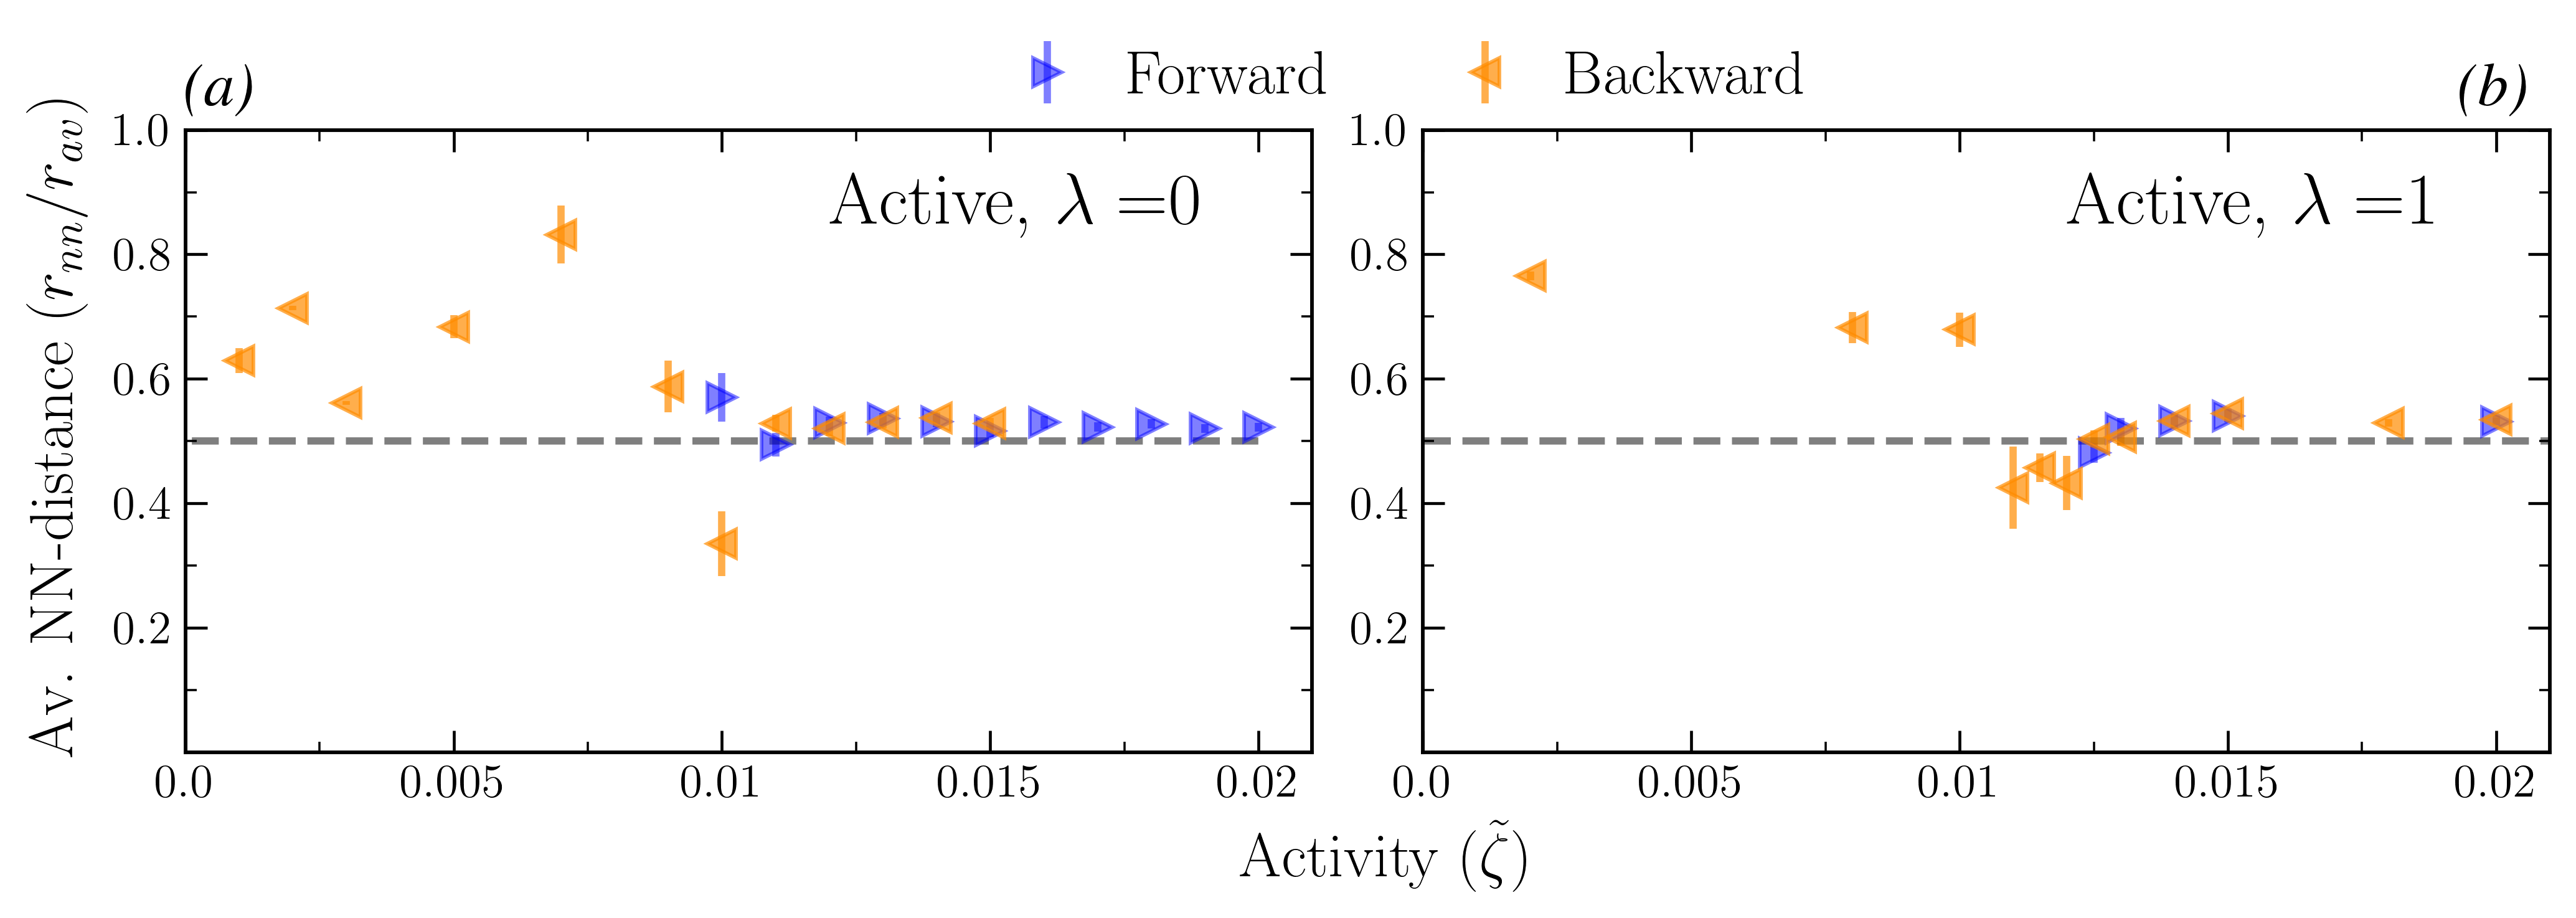

In [ ]:
### Active RNN plot ###

width=10
fig, ax0 = plt.subplots(ncols = 2, figsize=(width,width/2.8),)
act_min_idx_bck = 1
font_size = 17

if mode == 'ac':
  for i, ax in enumerate(ax0):
      
      out_path_all = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\{folder_name}\{mode}\\na{LX}'
      out_path_main = os.path.join(out_path_all, f'{lambda_val}') 
      out_path_fwd = os.path.join(out_path_main, 'fwd')
      out_path_bck = os.path.join(out_path_main, 'bck')

      lambda_val = lambda_list[i]

      act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
      act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
      act_bck = act_bck[act_min_idx_bck:]

      nn_arr_fwd_av = np.load(os.path.join(out_path_fwd, 'nn_av.npy'))
      nn_arr_bck_av = np.load(os.path.join(out_path_bck, 'nn_av.npy'))[act_min_idx_bck:]

      
      xticks=[0.0, 0.005, 0.01, 0.015, 0.02]
      yticks=[0.2, 0.4, 0.6, 0.8, 1.0]
      xtick_labels=[r'~~0.0', '0.005', '0.01', '0.015', '0.02']

      ax.set_xticks(xticks, xticks)
      ax.set_yticks(yticks, yticks)
      ax.tick_params(axis='both',which='major', labelsize=13)
      ax.set_ylim((0,1))#0.8))
      ax.set_xlim((0, act_fwd[-1] + 1e-3))
      ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
      ax.xaxis.set_minor_locator(ticker.MultipleLocator(2.5e-3))


      ax.errorbar(act_fwd, nn_arr_fwd_av[:,0], yerr=nn_arr_fwd_av[:,1], fmt='b>', alpha=.5, ms=8, label=rf'Forward' if i==0 else None,lw=1, elinewidth=2)#$\lambda = $ {lambda_val}')# label=r'$\overline{l_{max}}$')
      ax.errorbar(act_bck, nn_arr_bck_av[:,0], yerr=nn_arr_bck_av[:,1], fmt='<', color='darkorange', alpha=.7, ms=8, label=rf'Backward' if i==0 else None,lw=1, elinewidth=2)# label=r'$\overline{l_{max}}$')
      ax.hlines(0.5, -1, max(act_fwd[-1], act_bck[-1]), linestyle='--', color='black', alpha=0.5,)
      
      ax.text(0.012, 0.85, rf'Active, $\lambda = ${lambda_val}', fontsize=20)

  if letter_subfigs:
    for n, AXX in enumerate(ax0):
      AXX.text(0 if n==0 else .92, 1.04, rf"{{\fontfamily{{ntxtlf}}\selectfont\textit{{({string.ascii_lowercase[n]})}}}}", transform=AXX.transAxes,
              size=font_size,  weight='normal',)#fontstyle='italic',fontfamily="Times New Roman",)

  fig.supylabel(r'Av. NN-distance ($r_{nn}/r_{av}$)', fontsize=font_size, y=.57)
  fig.supxlabel((r'Activity ($\tilde\zeta$)'), fontsize=font_size, y=0.07, x=.54)
  fig.legend(fontsize=font_size,loc='upper center', bbox_to_anchor=(0.55, 1.03), ncol=2)

  fig.tight_layout() 
  if save_figs:
    fig.savefig(os.path.join(save_path, f'rnn_{mode}_v2.pdf'), dpi=520, bbox_inches='tight', pad_inches=.1) 
    fig.savefig(os.path.join(figpath_article, f'rnn_{mode}_v2.pdf'), dpi=520, bbox_inches='tight', pad_inches=.1) 

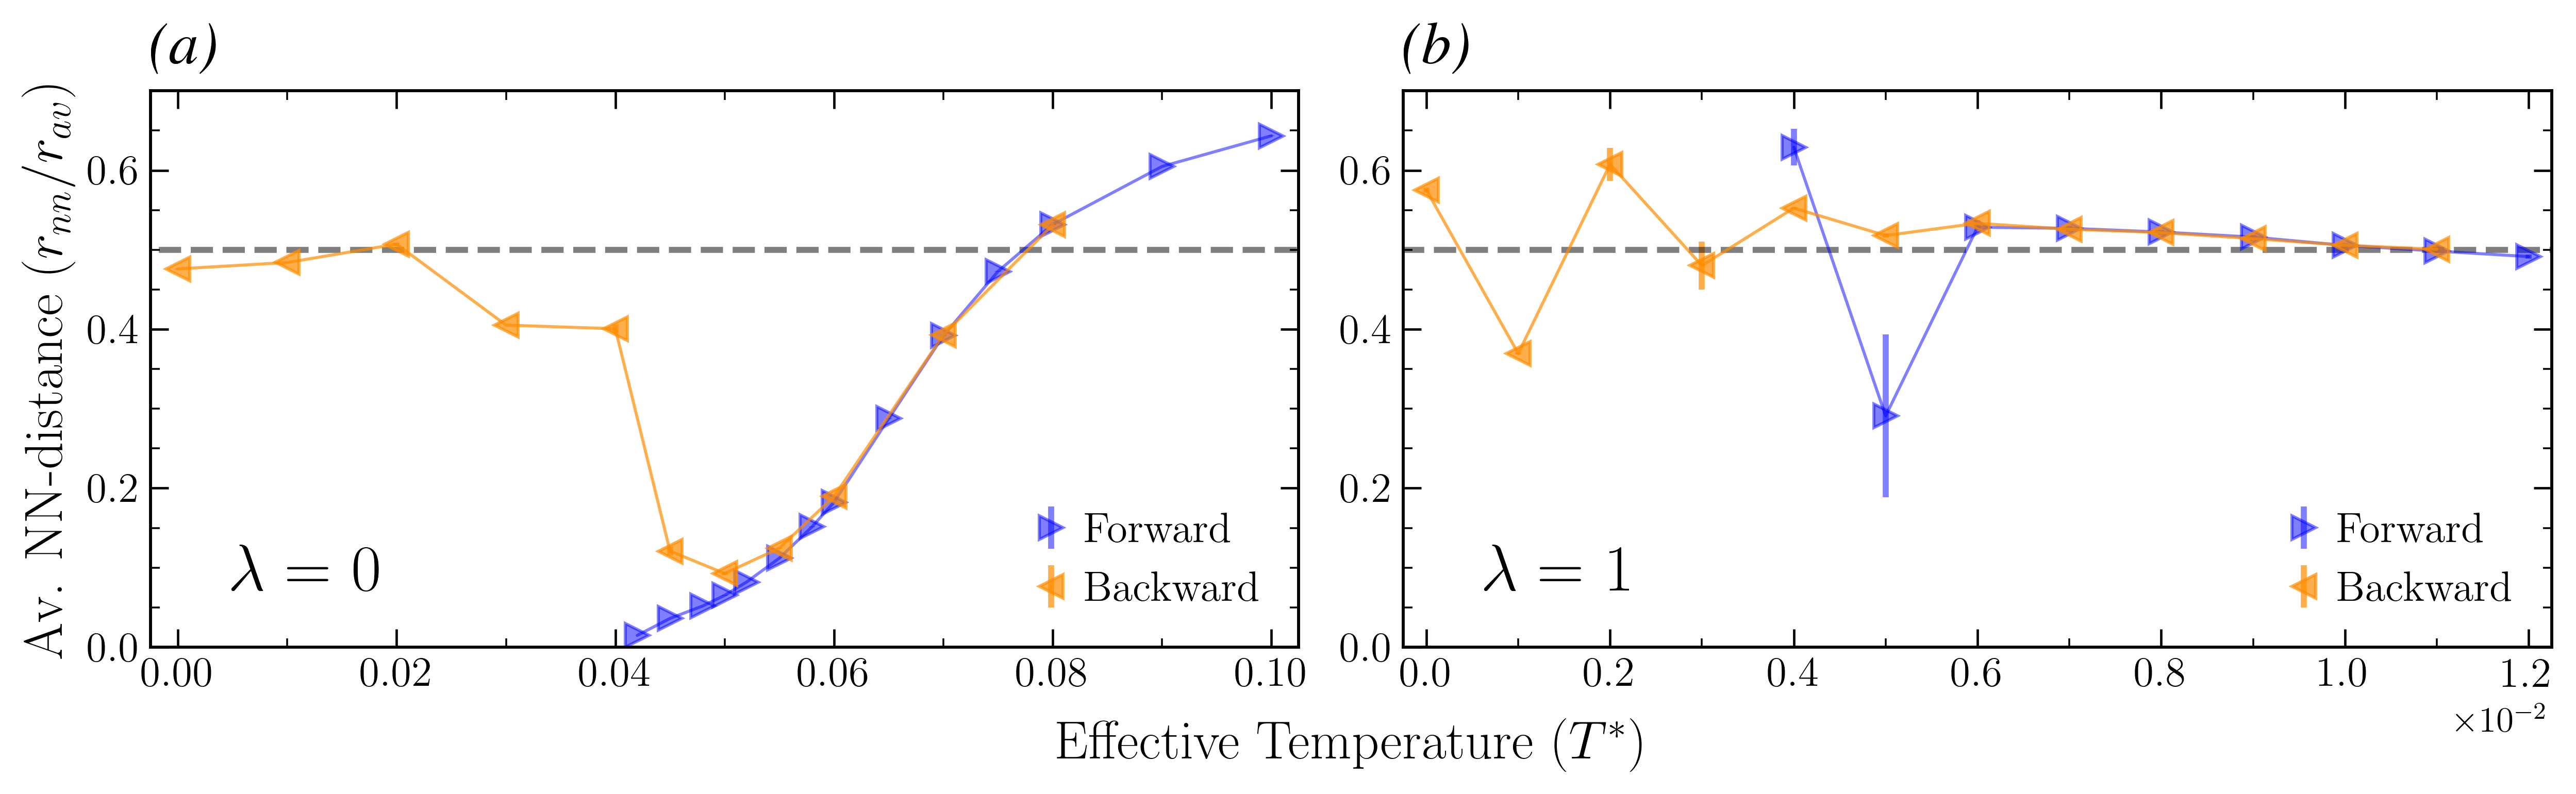

In [15]:
### Passive RNN plot ###

plt.rcParams.update({"text.usetex": True, "legend.fontsize": 14, 
                     "legend.handlelength": 0,
                     })

fig, ax = plt.subplots(ncols=2,figsize=(12, 4.))
ax = ax.flatten()
normalize=True
marker_list = ['dotted', 'dashed', 'dashdot']
ninfo = 1000

for i, lambda_val in enumerate([0, 1]):
    mode = 'wet'
    normalizer = LX if normalize else 1
    out_path_main = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda_periodic\\{mode}\\na{LX}\\{lambda_val}'
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
    def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))

    nn_arr_fwd = np.load(os.path.join(out_path_fwd, 'nn_arr.npy'))
    nn_arr_bck = np.load(os.path.join(out_path_bck, 'nn_arr.npy'))
    nn_arr_av_fwd = np.load(os.path.join(out_path_fwd, 'nn_av.npy'))
    nn_arr_av_bck = np.load(os.path.join(out_path_bck, 'nn_av.npy'))


    ax[i].errorbar(act_fwd, nn_arr_av_fwd[:,0], yerr=nn_arr_av_fwd[:,1], alpha=.5,ms=8,fmt='b>-', label=r'Forward', lw=1, elinewidth=2)# if i==0 else None)#$\overline{l_{max}}$ (Forward)' if i==0 else None)# label=r'$\overline{l_{max}}$')
    ax[i].errorbar(act_bck, nn_arr_av_bck[:,0], yerr=nn_arr_av_bck[:,1], fmt='<-',color='darkorange', alpha=.7, ms=8,lw=1, elinewidth=2, label=r'Backward')#  if i==0 else None) # $~~~~~~~~~\hspace{5em}$' if i==0 else None)# label=r'$\overline{l_{perc}}$')

    ax[i].set_ylim([0, .7])#0.8))
    ax[i].set_xlim([-2.5e-3 if i==0 else -2.5e-4, max(act_fwd[-1], act_bck[-1]) + 2.5e-3 if i==0 \
                    else max(act_fwd[-1], act_bck[-1]) + 2.5e-4])

  #  ax[i].set_xlabel(r'Effective Temperature ($T^*$)',)# x=1.1)
    ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(0.01 if i==0 else 0.001))
    ax[i].hlines(0.5, -.12,.12, linestyle='--', color='black', alpha=0.5,)

    ax[i].legend(fontsize=14, loc='lower right',) # handlelength=1, ncol=1) #if i==0 else None)
    ax[i].text(0.07, 0.1, rf'$\lambda = ~${lambda_val}', transform=ax[i].transAxes, fontsize=22)
    
    if 0:
        ###############################################################################
        xticks = [0, 2e5, 4e5, 6e5, 8e5,10e5]
        xticks_labels = ['0', '2', '4', '6', '8', '10']
        ax[2+i].set_xticks(xticks, xticks_labels)
        ax[2+i].text(0.04, 0.13, rf'$\lambda = ~${lambda_val} (Backward)', transform=ax[2+i].transAxes, fontsize=22)
        ax[2+i].set_xlim([0, 1e6])
        ax[2+i].xaxis.set_minor_locator(ticker.MultipleLocator(1e5))
        ax[2+i].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

        for j, temp in enumerate(act_bck[:3]):
            mask_bck = nn_arr_bck[:,0, j] > 0
            normalizer = LX / np.sqrt(def_arr_bck[mask_bck,j]) if normalize else 1
            xvals = np.arange(0, Nframes * ninfo, ninfo)[mask_bck]

            ax[2+i].plot(xvals, nn_arr_bck[mask_bck, 0, j] / normalizer, ls=marker_list[j], label = rf'$T^* = ${temp:.3f}')
            #ax[2+i].set_xlabel(r'Time step') # ($1/10^6$)')
            ax[2+i].set_ylim([0, 1])  

            ax[2+i].legend(ncols=3, loc='upper left',fontsize=14, handlelength=1)# if j==2 else 1)   

ax[0].set_ylabel(r'Av. NN-distance ($r_{nn}/r_{av}$)')
#ax[2].set_ylabel(r'NN-distance ($r_{nn}(t)/r_{av}(t)$)')
#fig.supxlabel(r'Time step ($10^5$)',x=.525,y=0.025)
fig.supxlabel(r'Effective Temperature ($T^*$)',x=.525,y=0.095)



for n, AXX in enumerate(ax):
    n0 = 0
    AXX.tick_params(axis='both',which='major', labelsize=14 if n==0 else 14)
    AXX.text(0.0 if n==0 else 0.0, 1.05, rf"{{\fontfamily{{ntxtlf}}\selectfont\textit{{({string.ascii_lowercase[n]})}}}}", transform=AXX.transAxes,
            size=20,  weight='normal',fontstyle='italic',fontfamily="Times New Roman", color = 'black' if letter_subfigs else 'white',)

fig.tight_layout()
save_path = os.path.join(out_path_all, 'figs')
if not os.path.isdir(save_path):
    os.makedirs(save_path)

if save_figs:
    fig.savefig(os.path.join(save_path, f'rnn_av_v2{"_unlabeled" if not letter_subfigs else ""}.png'), dpi=720, bbox_inches='tight', pad_inches=.1)
    fig.savefig(os.path.join(figpath_article, f'rnn_av_v2{"_unlabeled" if not letter_subfigs else ""}.png'), dpi=720, bbox_inches='tight', pad_inches=.1) 

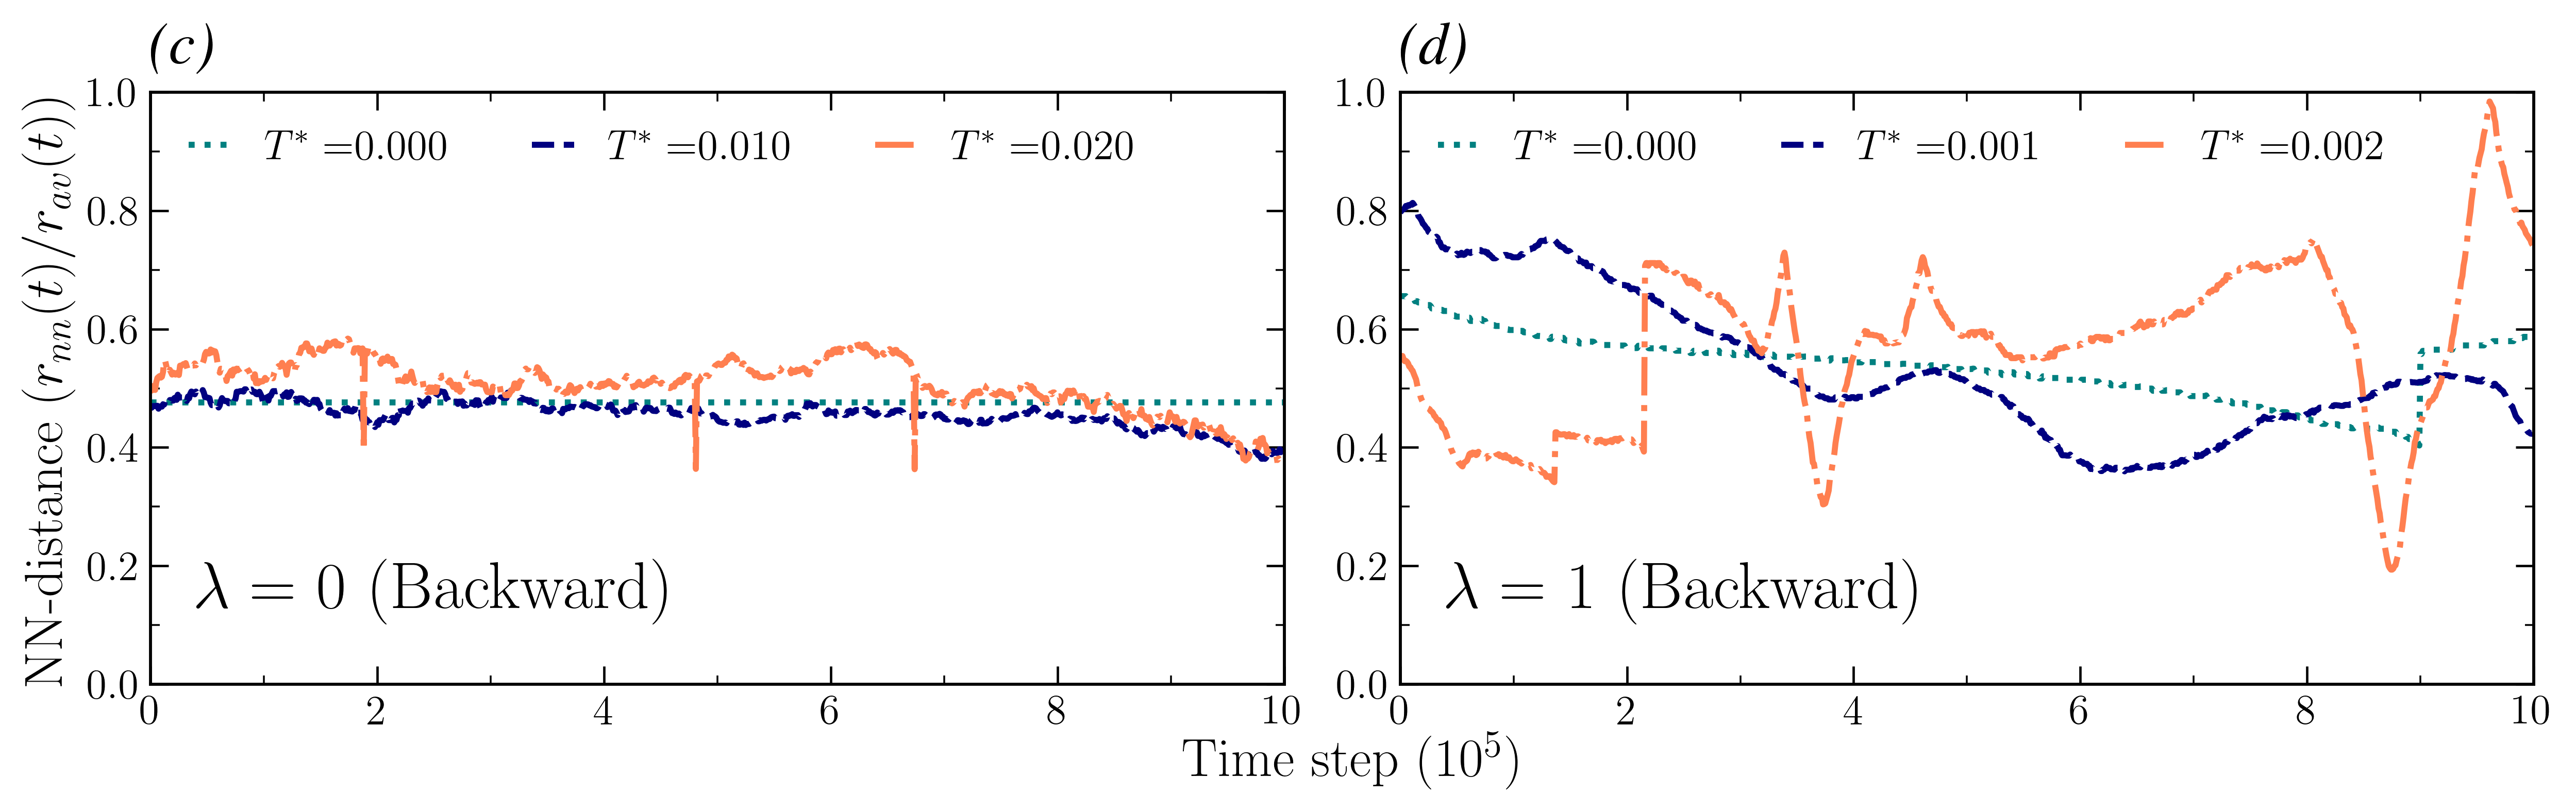

In [114]:
### Passive RNN time series plot ###

plt.rcParams.update({"text.usetex": True, "legend.fontsize": 14, 
                     "legend.handlelength": 0,
                     })


fig, ax = plt.subplots(ncols=2,figsize=(12, 4.))
ax = ax.flatten()
normalize=True
marker_list = ['dotted', 'dashed', 'dashdot']
ninfo = 1000

for k, lambda_val in enumerate([0, 1]):
    i = k - 2
    mode = 'wet'
    normalizer = LX if normalize else 1
    out_path_main = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda_periodic\\{mode}\\na{LX}\\{lambda_val}'
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
    def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))

    nn_arr_fwd = np.load(os.path.join(out_path_fwd, 'nn_arr.npy'))
    nn_arr_bck = np.load(os.path.join(out_path_bck, 'nn_arr.npy'))
    nn_arr_av_fwd = np.load(os.path.join(out_path_fwd, 'nn_av.npy'))
    nn_arr_av_bck = np.load(os.path.join(out_path_bck, 'nn_av.npy'))

    if 0:
        ax[i].errorbar(act_fwd, nn_arr_av_fwd[:,0], yerr=nn_arr_av_fwd[:,1], alpha=.5,ms=10,fmt='b*-', label=r'Forward')# if i==0 else None)#$\overline{l_{max}}$ (Forward)' if i==0 else None)# label=r'$\overline{l_{max}}$')
        ax[i].errorbar(act_bck, nn_arr_av_bck[:,0], yerr=nn_arr_av_bck[:,1], alpha=.5,ms=8, fmt='rd-', label=r'Backward')#  if i==0 else None) # $~~~~~~~~~\hspace{5em}$' if i==0 else None)# label=r'$\overline{l_{perc}}$')

        ax[i].set_ylim([0, .7])#0.8))
        ax[i].set_xlim([-2.5e-3 if i==0 else -2.5e-4, max(act_fwd[-1], act_bck[-1]) + 2.5e-3 if i==0 \
                        else max(act_fwd[-1], act_bck[-1]) + 2.5e-4])

    #  ax[i].set_xlabel(r'Effective Temperature ($T^*$)',)# x=1.1)
        ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
        ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(0.01 if i==0 else 0.001))
        ax[i].hlines(0.5, -.12,.12, linestyle='--', color='black', alpha=0.5,)

        ax[i].legend(fontsize=14, loc='lower right', handlelength=1, ncol=1) #if i==0 else None)
        ax[i].text(0.07, 0.1, rf'$\lambda = ~${lambda_val}', transform=ax[i].transAxes, fontsize=22)
    
    if 1:
        ###############################################################################
        xticks = [0, 2e5, 4e5, 6e5, 8e5,10e5]
        xticks_labels = ['0', '2', '4', '6', '8', '10']
        ax[2+i].set_xticks(xticks, xticks_labels)
        ax[2+i].text(0.04, 0.13, rf'$\lambda = ~${lambda_val} (Backward)', transform=ax[2+i].transAxes, fontsize=22)
        ax[2+i].set_xlim([0, 1e6])
        ax[2+i].xaxis.set_minor_locator(ticker.MultipleLocator(1e5))
        ax[2+i].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

        for j, temp in enumerate(act_bck[:3]):
            mask_bck = nn_arr_bck[:,0, j] > 0
            normalizer = LX / np.sqrt(def_arr_bck[mask_bck,j]) if normalize else 1
            xvals = np.arange(0, Nframes * ninfo, ninfo)[mask_bck]

            ax[2+i].plot(xvals, nn_arr_bck[mask_bck, 0, j] / normalizer, ls=marker_list[j], label = rf'$T^* = ${temp:.3f}')
            #ax[2+i].set_xlabel(r'Time step') # ($1/10^6$)')
            ax[2+i].set_ylim([0, 1])  

            ax[2+i].legend(ncols=3, loc='upper left',fontsize=14, handlelength=1)# if j==2 else 1)   

#ax[0].set_ylabel(r'Av. NN-distance ($r_{nn}/r_{av}$)')
ax[0].set_ylabel(r'NN-distance ($r_{nn}(t)/r_{av}(t)$)')
fig.supxlabel(r'Time step ($10^5$)',x=.525,y=0.075)
#fig.supxlabel(r'Effective Temperature ($T^*$)',x=.525,y=0.095)

for n, AXX in enumerate(ax):
    n0 = 2
    AXX.tick_params(axis='both',which='major', labelsize=14 if n==0 else 14)
   # AXX.text(0 if n==0 else .55, 1.025, rf'{{({string.ascii_lowercase[n0 + n]})}}', transform=AXX.transAxes,
   #         size=20, weight='normal')
    AXX.text(0 if n==0 else 0.0, 1.05, rf"{{\fontfamily{{ntxtlf}}\selectfont\textit{{({string.ascii_lowercase[n0+n]})}}}}", transform=AXX.transAxes,
            size=20,  weight='normal',fontstyle='italic',fontfamily="Times New Roman", color = 'black' if letter_subfigs else 'white',)

fig.tight_layout()
save_path = os.path.join(out_path_all, 'figs')
if not os.path.isdir(save_path):
    os.makedirs(save_path)

if save_figs:
    fig.savefig(os.path.join(save_path, f'rnn_time_v2{"_unlabeled" if not letter_subfigs else ""}.png'), dpi=720, bbox_inches='tight', pad_inches=.1)
    fig.savefig(os.path.join(figpath_article, f'rnn_time_v2{"_unlabeled" if not letter_subfigs else ""}.png'), dpi=720, bbox_inches='tight', pad_inches=.1) 

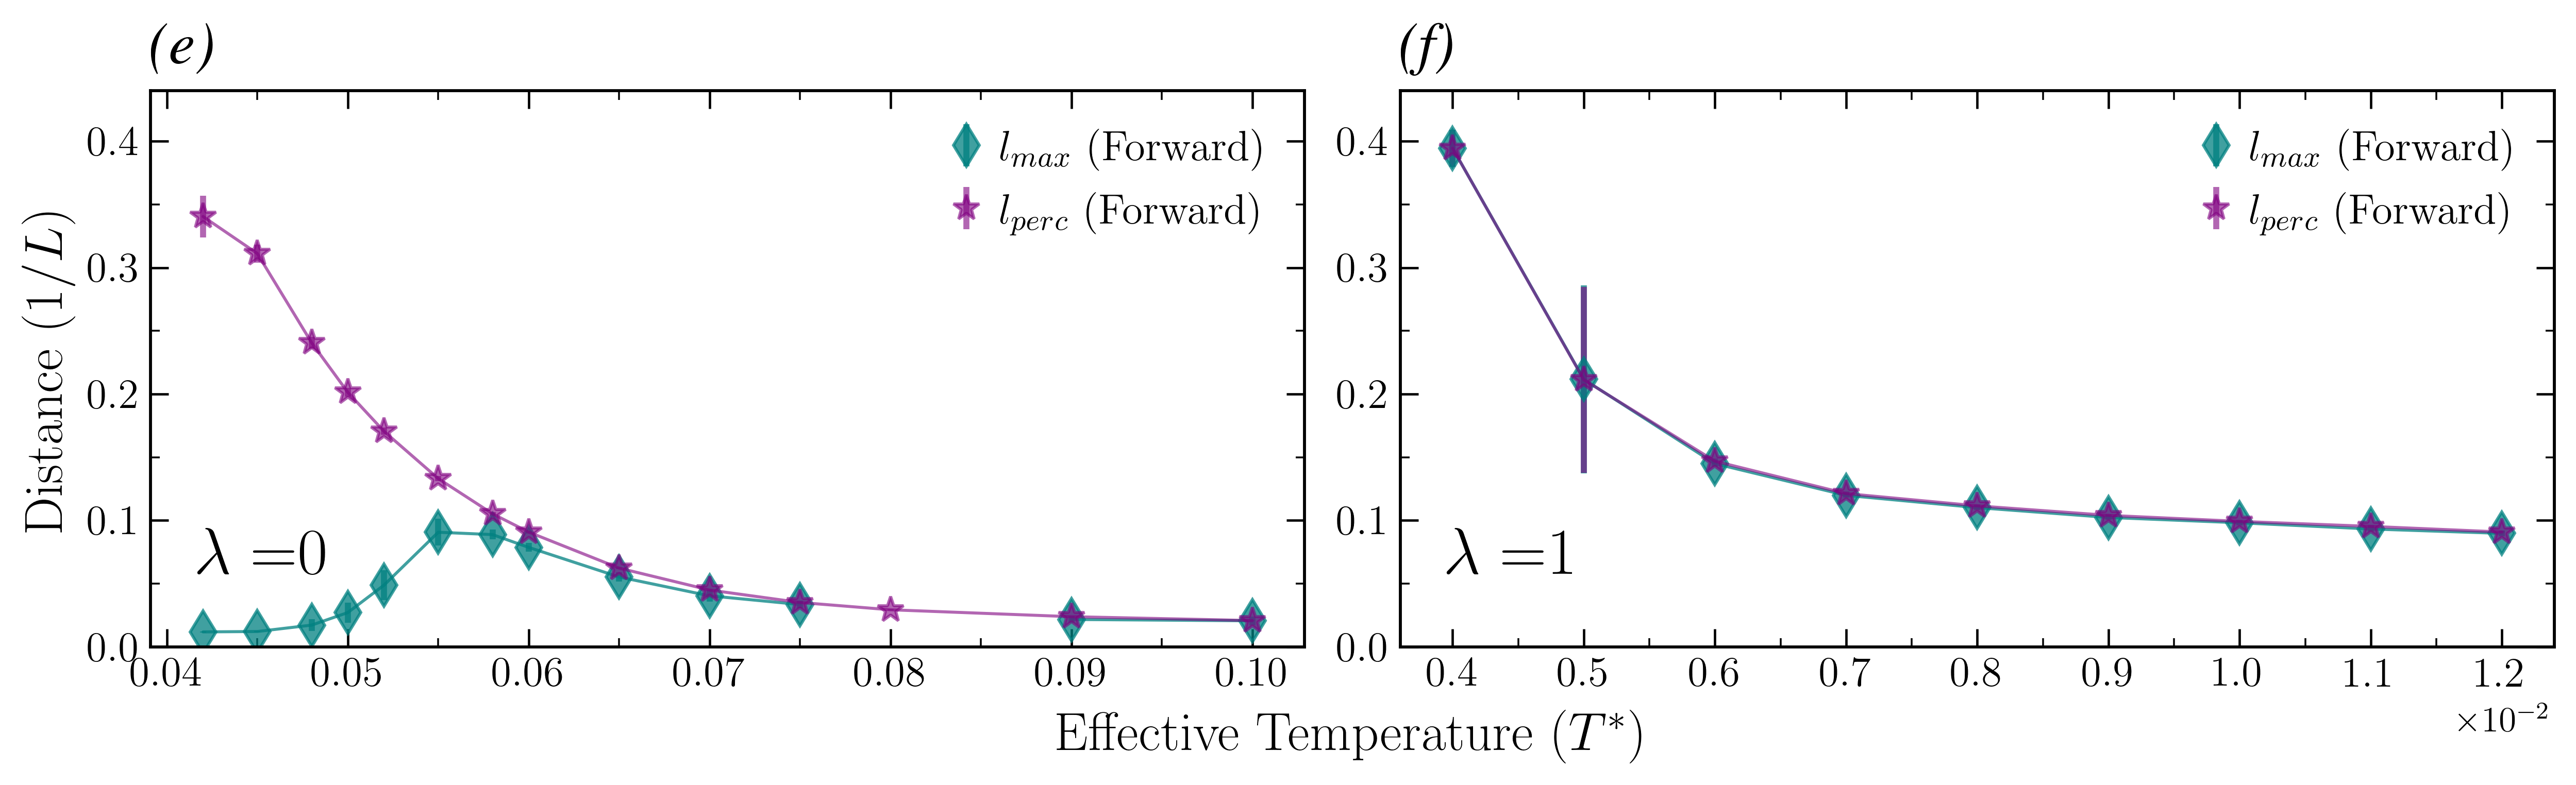

In [113]:
### Passive lmax, lperc plot ###

plot_bck = False

plt.rcParams.update({"text.usetex": True, "legend.fontsize": 14, 
                     "legend.handlelength": 0,
                     })

fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax = ax.flatten()
normalize=True
marker_list = ['dotted', 'dashed', 'dashdot']

for i, lambda_val in enumerate([0, 1]):
    mode = 'wet'
    normalizer = LX if normalize else 1
    out_path_main = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda_periodic\\{mode}\\na{LX}\\{lambda_val}'
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    lmax_av_fwd = np.load(os.path.join(out_path_fwd, 'lmax_av.npy')) / normalizer
    lperc_av_fwd = np.load(os.path.join(out_path_fwd, 'lperc_av.npy')) / normalizer
    lmax_av_bck = np.load(os.path.join(out_path_bck, 'lmax_av.npy')) / normalizer
    lperc_av_bck = np.load(os.path.join(out_path_bck, 'lperc_av.npy')) / normalizer
    nn_arr_fwd = np.load(os.path.join(out_path_fwd, 'nn_arr.npy'))
    nn_arr_bck = np.load(os.path.join(out_path_bck, 'nn_arr.npy'))
    def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
    def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))


    ax[i].errorbar(act_fwd, lmax_av_fwd[:,0], yerr=lmax_av_fwd[:,1], alpha=.75,ms=10,fmt='d-', label=r'$l_{max}$ (Forward)', lw=1, elinewidth=2, )#if i==0 else None)# label=r'$\overline{l_{max}}$')
    ax[i].errorbar(act_fwd, lperc_av_fwd[:,0], yerr=lperc_av_fwd[:,1], alpha=.6,ms=9, fmt='*-',color='blue' if plot_bck else f'C{3}', lw=1, elinewidth=2, label=r'$l_{perc}$ (Forward) $~~~~~~~~~\hspace{5em}$')# if i==0 else None)# label=r'$\overline{l_{perc}}$')

    if plot_bck:
        ax[i].errorbar(act_bck, lmax_av_bck[:,0], yerr=lmax_av_bck[:,1], alpha=.5, ms=8,fmt='r^-', label=r'$l_{max}$ (Backward)')# if i==0 else None)# label=r'$\overline{l_{max}}$')
        ax[i].errorbar(act_bck, lperc_av_bck[:,0], yerr=lperc_av_bck[:,1], ms=8,alpha=.5,fmt='rv-', label=r'$l_{perc}$ (Backward)')# if i==0 else None)# label=r'$\overline{l_{perc}}$')
        ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
        ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(0.01 if i==0 else 0.001))
    if not plot_bck:
        ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
        ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(0.005 if i==0 else 0.0005))

    ax[i].set_ylim([0, .44])#0.8))
    ax[i].text(0.04, 0.13, rf'$\lambda = ${lambda_val}', transform=ax[i].transAxes, fontsize=22)
   # ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
   # ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(0.01 if i==0 else 0.001))

    ax[i].legend(fontsize=14, loc='upper right', handlelength=0, ncol=1) #if i==0 else None)

    ###############################################################################


ax[0].set_ylabel(r'Distance ($1/L$)')
fig.supxlabel(r'Effective Temperature ($T^*$)',x=0.525,y=.105)

labels = []
handles = []

for errorbar in ax[0].containers:  # Accessing all the containers (including ErrorbarContainer)
    labels.append(errorbar.get_label())
    handles.append(errorbar)


for n, AXX in enumerate(ax):
  n0=4
  AXX.tick_params(axis='both',which='major', labelsize=14 if n==0 else 14)
  AXX.text(0 if n==0 else 0, 1.05, rf"{{\fontfamily{{ntxtlf}}\selectfont\textit{{({string.ascii_lowercase[n0+n]})}}}}", transform=AXX.transAxes,
          size=20,  weight='normal',fontstyle='italic',fontfamily="Times New Roman", color = 'black' if letter_subfigs else 'white',)
fig.tight_layout()
save_path = os.path.join(out_path_all, 'figs')
if not os.path.isdir(save_path):
    os.makedirs(save_path)

if save_figs:
    fig.savefig(os.path.join(save_path, f'lmax_lperc_v2{"_unlabeled" if not letter_subfigs else ""}.png'), dpi=720, bbox_inches='tight', pad_inches=.1)
    fig.savefig(os.path.join(figpath_article, f'lmax_lperc_v2{"_unlabeled" if not letter_subfigs else ""}.png'), dpi=720, bbox_inches='tight', pad_inches=.1) 

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_9296\1687182417.py:32: RuntimeWarning: divide by zero encountered in divide
  rel_diff_fwd = np.abs(np.diff(def_arr_fwd, axis=0)) / def_arr_fwd[:-1]
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_9296\1687182417.py:32: RuntimeWarning: invalid value encountered in divide
  rel_diff_fwd = np.abs(np.diff(def_arr_fwd, axis=0)) / def_arr_fwd[:-1]
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\lib\nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


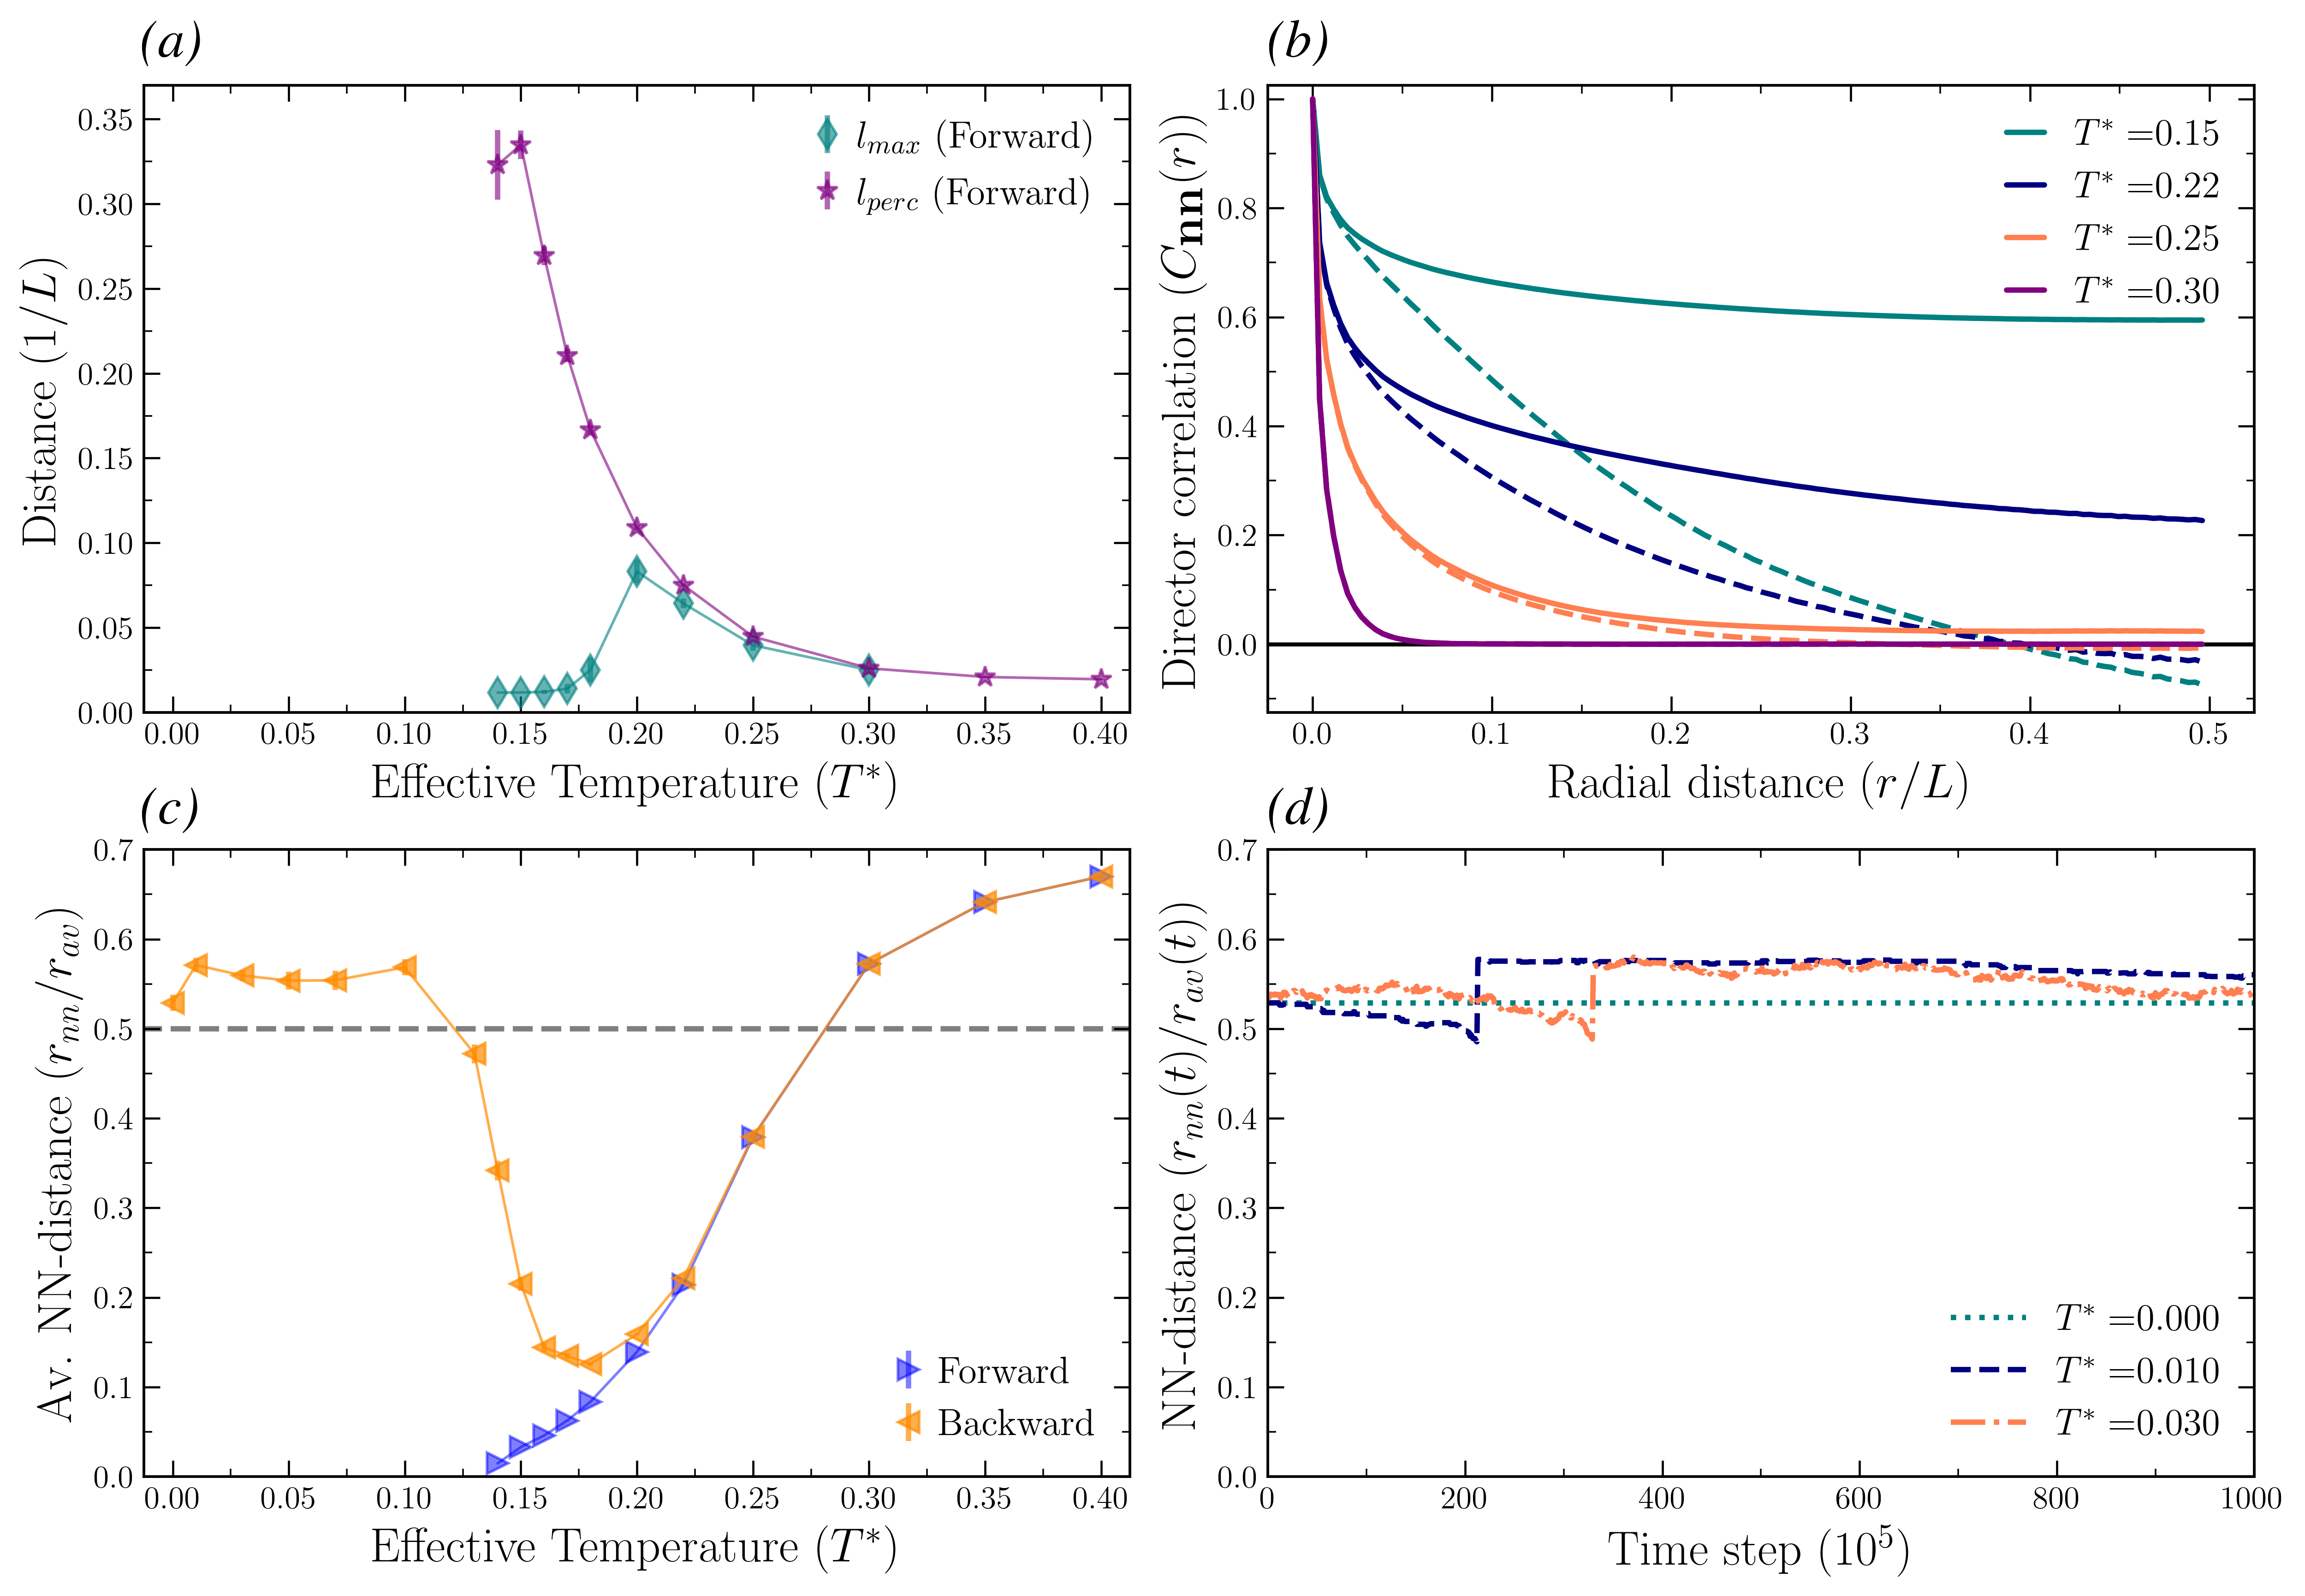

In [21]:
### Passive superfigure ###
plt.rcParams.update({"text.usetex": True, "legend.fontsize": 14})
marker_list = ['dotted', 'dashed', 'dashdot']
plot_lmperc_bck = False
act_fwd_idx_min = 2


if mode == 'dry':

    fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(12, 8))
    ax = ax.flatten()

    normalize=True
    nmin_samples=5
    normalizer = LX if normalize else 1

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    conv_list_fwd = np.load(os.path.join(out_path_fwd, 'conv_list.npy'))
    conv_list_bck = np.load(os.path.join(out_path_bck, 'conv_list.npy'))
    def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))
    def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
    lmax_av_fwd = np.load(os.path.join(out_path_fwd, 'lmax_av.npy')) / normalizer
    lperc_av_fwd = np.load(os.path.join(out_path_fwd, 'lperc_av.npy')) / normalizer
    lmax_av_bck = np.load(os.path.join(out_path_bck, 'lmax_av.npy')) / normalizer
    lperc_av_bck = np.load(os.path.join(out_path_bck, 'lperc_av.npy')) / normalizer
    
    rvals = np.load(os.path.join(out_path_fwd, 'rvals.npy'))
    rdf_arr_av_bck = np.load(os.path.join(out_path_bck, 'rdf_arr_av.npy'))
    rdf_arr_av_fwd = np.load(os.path.join(out_path_fwd, 'rdf_arr_av.npy'))

    rel_diff_fwd = np.abs(np.diff(def_arr_fwd, axis=0)) / def_arr_fwd[:-1]
    rel_diff_bck = np.abs(np.diff(def_arr_bck, axis=0)) / def_arr_bck[:-1]

    rel_diff_fwd_av = np.nanmean(rel_diff_fwd, axis=0)
    rel_diff_fwd_std = np.nanstd(rel_diff_fwd, axis=0) / np.sqrt(rel_diff_fwd.shape[0])
    rel_diff_bck_av = np.nanmean(rel_diff_bck, axis=0)
    rel_diff_bck_std = np.nanstd(rel_diff_bck, axis=0) / np.sqrt(rel_diff_bck.shape[0])

    

    nn_arr_fwd = np.load(os.path.join(out_path_fwd, 'nn_arr.npy'))
    nn_arr_bck = np.load(os.path.join(out_path_bck, 'nn_arr.npy'))

    nn_arr_fwd_av = np.load(os.path.join(out_path_fwd, 'nn_av.npy'))
    nn_arr_bck_av = np.load(os.path.join(out_path_bck, 'nn_av.npy'))
    nn_arr_fwd_weighted_av = np.nan * np.zeros((len(act_fwd),2))

    
    ax[2].errorbar(act_fwd[act_fwd_idx_min:], nn_arr_fwd_av[act_fwd_idx_min:,0], yerr=nn_arr_fwd_av[act_fwd_idx_min:,1], alpha=.5,ms=8,fmt='b>-', label=r'Forward', lw=1, elinewidth=2)# if i==0 else None)#$\overline{l_{max}}$ (Forward)' if i==0 else None)# label=r'$\overline{l_{max}}$')
    ax[2].errorbar(act_bck, nn_arr_bck_av[:,0], yerr=nn_arr_bck_av[:,1], fmt='<-',color='darkorange', alpha=.7, ms=8,lw=1, elinewidth=2, label=r'Backward')#  if i==0 else None) # $~~~~~~~~~\hspace{5em}$' if i==0 else None)# label=r'$\overline{l_{perc}}$')
    ax[2].hlines(0.5, -.1, max(act_fwd[-1], act_bck[-1])+.1, linestyle='--', color='black', alpha=0.5,
                    )#label='Uniform')# if i==0 else None) 
    ax[2].set_ylabel(r'Av. NN-distance ($r_{nn}/r_{av}$)')
    ax[2].set_xlabel((r'Effective Temperature ($T^*$)'))
    ax[2].set_ylim([0, .7])
    ax[2].set_xlim(([-0.0125, 0.4125]))
    ax[2].legend(loc='lower right')


    # ------------------------------------
    if not plot_lmperc_bck:
        ax[0].errorbar(act_fwd[act_fwd_idx_min:], lmax_av_fwd[act_fwd_idx_min:,0], yerr=lmax_av_fwd[act_fwd_idx_min:,1], alpha=.6,ms=8,fmt='d-', label=r'$l_{max}$ (Forward)', lw=1, elinewidth=2, )#if i==0 else None)# label=r'$\overline{l_{max}}$')
        ax[0].errorbar(act_fwd[act_fwd_idx_min:], lperc_av_fwd[act_fwd_idx_min:,0], yerr=lperc_av_fwd[act_fwd_idx_min:,1], alpha=.6,ms=8, fmt='*-',color=f'C{3}', lw=1, elinewidth=2, label=r'$l_{perc}$ (Forward) $~~~~~~~~~\hspace{5em}$')# if i==0 else None)# label=r'$\overline{l_{perc}}$')

    if plot_lmperc_bck:
        ax[0].errorbar(act_fwd, lmax_av_fwd[:,0], yerr=lmax_av_fwd[:,1], alpha=.5,ms=8,fmt='bs-', label=r'$l_{max}$ (Forward)')# label=r'$\overline{l_{max}}$')
        ax[0].errorbar(act_fwd, lperc_av_fwd[:,0], yerr=lperc_av_fwd[:,1], alpha=.5,ms=8, fmt='o-',color='blue', label=r'$l_{perc}$ (Forward)')# label=r'$\overline{l_{perc}}$')
    
        ax[0].errorbar(act_bck, lmax_av_bck[:,0], yerr=lmax_av_bck[:,1], alpha=.5, ms=8,fmt='r^-', label=r'$l_{max}$ (Backward)')# label=r'$\overline{l_{max}}$')
        ax[0].errorbar(act_bck, lperc_av_bck[:,0], yerr=lperc_av_bck[:,1], ms=8,alpha=.5,fmt='rv-', label=r'$l_{perc}$ (Backward)')# label=r'$\overline{l_{perc}}$')
    ax[0].set_xlabel(r'Effective Temperature ($T^*$)')
    ax[0].set_ylabel(r'Distance ($1/L$)')
    ax[0].legend()
    ax[0].set_ylim([0, .37])
    ax[0].set_xlim(([-0.0125, 0.4125]))

    # ------------------------------------
    act_include_list = [.15, .22, .25, .30]

    ax[1].set_xlabel((r'Radial distance ($r/L$)'))

    ax[1].set_ylabel(r'Director correlation ($C_{\textbf{nn}} (r)$)')

    for j, act in enumerate(act_include_list):
        #act_idx_fwd = np.argwhere(act_fwd == act)[0][0]
        #act_idx_bck = np.argwhere(act_bck == act)[0][0]
        try:
            act_idx_fwd = np.argwhere(act_fwd == act)[0][0]
            ax[1].plot(rvals/LX, rdf_arr_av_fwd[act_idx_fwd, 0,:],'-', color=f'C{j}',  label = rf'$T^* = ${act:.2f}')
        except:
            pass
        try:
            act_idx_bck = np.argwhere(act_bck == act)[0][0]
            ax[1].plot(rvals/LX, rdf_arr_av_bck[act_idx_bck, 0,:],ls='dashed', color=f'C{j}',)# label = rf'$T^* = ${act:.3f}' if j==0 else None) # $~~~~~~~~~\hspace{5em}$' if i==0 else None)# label=r'$\overline{l_{perc}}$')
        except:
            pass

    ax[1].legend(loc='upper right', handlelength=1, ncol=1) #if i==0 else None)
    ax[1].set_xlim([-.025,.525])
    ax[1].set_ylim([-.125, 1.025])
    ax[1].hlines(0, -.1, .6, linestyle='-', lw=1.5, color='black', alpha=1,zorder=-1)
    # ------------------------------------

    ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(0.025))
    ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(0.025))

    ax[1].xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    ax[1].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

    ax[2].xaxis.set_minor_locator(ticker.MultipleLocator(0.025))
    ax[2].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))

    ax[3].xaxis.set_minor_locator(ticker.MultipleLocator(100))
    ax[3].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    #ax[3].set_ylim([-0.05,1])
    ax[3].set_ylim([.0, .7])
    ax[3].set_xlim((0, Nframes))


    for j, T in enumerate(act_bck[:3]):
        mask_bck = nn_arr_bck[:,0, j] > 0
        normalizer = LX / np.sqrt(def_arr_bck[mask_bck,j]) if normalize else 1

        if mask_bck.sum() < nmin_samples: 
            print(f'Not enough samples for {T}')
            continue


        ax[3].plot(np.arange(Nframes)[mask_bck], nn_arr_bck[mask_bck, 0, j] / normalizer, ls=marker_list[j],
                    label = rf'$T^* = ${T:.3f}')
    ax[3].legend(handlelength=2, ncols=1, loc='lower right')

    ax[3].set_ylabel(r'NN-distance ($r_{nn}(t)/r_{av}(t)$)')
    ax[3].set_xlabel((r'Time step ($10^5$)'))
                

    if letter_subfigs:
        for n, AXX in enumerate(ax):
            fig.text(0.065 if n%2==0 else 0.55, 1.0 if n<2 else 0.505, rf"{{\fontfamily{{ntxtlf}}\selectfont\textit{{({string.ascii_lowercase[n]})}}}}",# transform=AXX.transAxes,
                    size=20,  weight='bold',fontstyle='italic', fontfamily="Times New Roman",)
    else:  
        for n, AXX in enumerate(ax):
            fig.text(0.065 if n%2==0 else 0.55, 1.0 if n<2 else 0.505, rf'$\it{{({string.ascii_lowercase[n]})}}$',# transform=AXX.transAxes,
                    size=20,  weight='bold',fontstyle='italic', fontfamily="Times New Roman", color= 'white')
    
    save_path = os.path.join(out_path_all, 'figs')
    fig.tight_layout()
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    if save_figs:
        fig.savefig(os.path.join(save_path, f'fig5{"_unlabeled" if not letter_subfigs else ""}.pdf'), bbox_inches='tight', pad_inches=.1, dpi=520)
        fig.savefig(os.path.join(figpath_article, f'fig5{"_unlabeled" if not letter_subfigs else ""}.pdf'), bbox_inches='tight', pad_inches=.1, dpi=520)

In [ ]:
### Passive director correlation plot ###

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

normalize=True
nmin_samples=5
normalizer = LX if normalize else 1

act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))

rvals = np.load(os.path.join(out_path_fwd, 'rvals.npy'))
rdf_arr_av_bck = np.load(os.path.join(out_path_bck, 'rdf_arr_av.npy'))
rdf_arr_av_fwd = np.load(os.path.join(out_path_fwd, 'rdf_arr_av.npy'))


act_include_list = [.15, .22, .25, .30]
bck_idx = int(rdf_arr_av_bck.shape[-1] / 2)
print(rvals[bck_idx])

ax[0].errorbar(act_fwd, rdf_arr_av_fwd[:,0,-1], yerr=rdf_arr_av_fwd[:,1,-1], alpha=.5,ms=8,fmt='b>-', label=r'Forward', lw=1, elinewidth=2)# if i==0 else None)#$\overline{l_{max}}$ (Forward)' if i==0 else None)# label=r'$\overline{l_{max}}$')
ax[0].errorbar(act_bck, rdf_arr_av_bck[:,0,bck_idx], yerr=rdf_arr_av_bck[:,1,bck_idx], fmt='<-',color='darkorange', alpha=.7, ms=8,lw=1, elinewidth=2, label=r'Backward')#  if i==0 else None) # $~~~~~~~~~\hspace{5em}$' if i==0 else None)# label=r'$\overline{l_{perc}}$')
ax[0].set_ylabel(r'Director correlation ($C_{\textbf{nn}} (r\to\infty)$)')
ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
#ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(0.025))
#   ax[1].errorbar(act_fwd, rel_diff_fwd_av[:len(act_fwd)], yerr=rel_diff_fwd_std[:len(act_fwd)], alpha=.5,ms=10,fmt='bo-', label=rf'Forward')#$\lambda = $ {lambda_val}')# label=r'$\overline{l_{max}}$')
#  ax[1].errorbar(act_bck, rel_diff_bck_av[:len(act_bck)], yerr=rel_diff_bck_std[:len(act_bck)], alpha=.5, ms=10,fmt='ro-', label=rf'Backward')# label=r'$\overline{l_{max}}$')
# ax[1].set_ylabel(r'$\langle[[N(t+1)-N(t)] / N(t)] \rangle$')
ax[1].set_xlabel((r'Radial distance ($r/L$)'))

ax[1].set_ylabel(r'Director correlation ($C_{\textbf{nn}} (r)$)')

for j, act in enumerate(act_include_list):
    #act_idx_fwd = np.argwhere(act_fwd == act)[0][0]
    #act_idx_bck = np.argwhere(act_bck == act)[0][0]
    try:
        act_idx_fwd = np.argwhere(act_fwd == act)[0][0]
        ax[1].plot(rvals/LX, rdf_arr_av_fwd[act_idx_fwd, 0,:],'-', color=f'C{j}',  label = rf'$T^* = ${act:.2f}')
    except:
        pass
    try:
        act_idx_bck = np.argwhere(act_bck == act)[0][0]
        ax[1].plot(rvals/LX, rdf_arr_av_bck[act_idx_bck, 0,:],ls='dashed', color=f'C{j}',)# label = rf'$T^* = ${act:.3f}' if j==0 else None) # $~~~~~~~~~\hspace{5em}$' if i==0 else None)# label=r'$\overline{l_{perc}}$')
    except:
        pass

ax[1].legend(loc='upper right', handlelength=1, ncol=1) #if i==0 else None)
ax[1].set_xlim([-.025,.525])
ax[1].set_ylim([-.125, 1.025])

### Make frame figs

In [ ]:
basepath = 'D:\\jayeeta\\aniso\\datas'
base_path_dry = os.path.join(basepath, 'dry_sample\\hys\\size_256\\run-fwd')
base_path_wet0 = os.path.join(basepath, 'diff_lambda\\lambda_0\\size_256\\run-fwd')
base_path_wet1 = os.path.join(basepath, 'diff_lambda\\lambda_1\\size_256\\run-fwd')

dry_sorted =glob.glob(os.path.join(base_path_dry, '*out2'))
wet0_sorted =glob.glob(os.path.join(base_path_wet0, '*out2'))
wet1_sorted =glob.glob(os.path.join(base_path_wet1, '*out2'))
acts_dry = [0.1, 0.15, 0.25]
acts_wet0 = [0.042, 0.045, 0.07]
acts_wet1 = [0.003, 0.006, 0.011]

if mode == 'dry':
    act_list = acts_dry
    act_idx_list = [np.where(act_fwd == act)[0][0] for act in act_list]
    paths = [dry_sorted[i] for i in act_idx_list]
elif mode == 'wet' and lambda_val == 1:
    act_list = acts_wet1
    act_idx_list = [np.where(act_fwd == act)[0][0] for act in act_list]
    paths = [wet1_sorted[i] for i in act_idx_list]
elif mode == 'wet' and lambda_val == 0:
    act_list = acts_wet0
    act_idx_list = [np.where(act_fwd == act)[0][0] for act in act_list]
    paths = [wet0_sorted[i] for i in act_idx_list]
paths

frame_list = []
for i, path in enumerate(paths[:]):
    
    fn = 20 if lambda_val == 0 else 600
    ar = mp.archive.loadarchive(path)

    f = get_frame_number(fn, path, ar.ninfo)
    frame = ar._read_frame(f)
    #ax[i].set_title(f'Activity = {act_list2[i]}')

    frame_list.append(frame)

In [ ]:

ncols = 4
w = 15 * ncols/4
wdens = .28
wframe = .22
fig, ax0 = plt.subplot_mosaic("ABCD",figsize=(w,4), width_ratios=[wdens, wframe, wframe, wframe], empty_sentinel=None)
axx = ax0['A']
ax = [ax0['B'], ax0['C'], ax0['D']]

LX = ar.LX
LY = ar.LY

act_min_idx_bck = 0
font_size = 16

if mode == 'dry':
    xt_minor, yt_minor = 0.05, 0.01
elif mode == 'wet':
    if lambda_val == 0:
        xt_minor, yt_minor = 0.01, 0.01
    elif lambda_val == 1:
        xt_minor, yt_minor = 0.001, 0.0005


out_path_all = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\{folder_name}\{mode}\\na{LX}'
out_path_main = os.path.join(out_path_all, f'{lambda_val}') 
out_path_fwd = os.path.join(out_path_main, 'fwd')
out_path_bck = os.path.join(out_path_main, 'bck')

act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
conv_list_fwd = np.load(os.path.join(out_path_fwd, 'conv_list.npy'))
conv_list_bck = np.load(os.path.join(out_path_bck, 'conv_list.npy'))
act_bck = act_bck[act_min_idx_bck:]

nn_arr_fwd_av = np.load(os.path.join(out_path_fwd, 'nn_av.npy'))
nn_arr_bck_av = np.load(os.path.join(out_path_bck, 'nn_av.npy'))[act_min_idx_bck:]

normalizer = LX ** 2
uncertainty_multiplier = 20
def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))
def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))[act_min_idx_bck:]
def_arr_fwd_av = np.nan * np.zeros((len(act_fwd), 2))
def_arr_bck_av = np.nan * np.zeros((len(act_bck), 2))

for j, T in enumerate(act_fwd):
    arr_res = def_arr_fwd[int(conv_list_fwd[j]):,j]
    nsamples = arr_res.size
    def_arr_fwd_av[j,0] = np.nanmean(arr_res)
    def_arr_fwd_av[j,1] = np.nanstd(arr_res, ddof = 1,) / np.sqrt(nsamples / uncertainty_multiplier)
    
for j, T in enumerate(act_bck):
    arr_res = def_arr_bck[int(conv_list_bck[j]):,j]
    nsamples = arr_res.size
    def_arr_bck_av[j,0] = np.nanmean(arr_res)
    def_arr_bck_av[j,1] = np.nanstd(arr_res, ddof = 1,) / np.sqrt(nsamples / uncertainty_multiplier)

nanmask_fwd = def_arr_fwd_av[:,0] > 0
nanmask_bck = def_arr_bck_av[:,0] > 0
def_arr_fwd_av[~nanmask_fwd,:] = [np.nan, np.nan]
def_arr_bck_av[~nanmask_bck,:] = [np.nan, np.nan]
def_arr_fwd_av /= normalizer
def_arr_bck_av /= normalizer
  
if mode=='dry':
    act_idx_min = 1
    act_fwd = act_fwd[act_idx_min:]
    def_arr_fwd_av = def_arr_fwd_av[act_idx_min:,:]
    act_bck = act_bck[act_idx_min:]
    def_arr_bck_av = def_arr_bck_av[act_idx_min:,:]

axx.errorbar(act_fwd, def_arr_fwd_av[:,0], yerr=def_arr_fwd_av[:,1], fmt='b>', alpha=.5, ms=10, label=rf'Forward')#$\lambda = $ {lambda_val}')# label=r'$\overline{l_{max}}$')
axx.errorbar(act_bck, def_arr_bck_av[:,0], yerr=def_arr_bck_av[:,1], fmt='<',color='darkorange', alpha=.7, ms=10, label=rf'Backward')# label=r'$\overline{l_{max}}$')

axx.yaxis.set_minor_locator(ticker.MultipleLocator(yt_minor))
axx.xaxis.set_minor_locator(ticker.MultipleLocator(xt_minor))
axx.tick_params(axis='both',which='major', labelsize=13)
axx.set_ylabel(r'Av. defect density ($\rho_{D}$)',) # y=.525) # fontsize=font_size, y=.525)
axx.set_xlabel(r'Effective Temperature ($T^*$)',x=.525,y=0.095)
axx.legend(fontsize=font_size, loc='upper left')

if mode == 'wet' and lambda_val == 1:
   xticks=[0.0, 0.002, 0.01, 0.015, 0.02]
if mode == 'dry':
    tdc_val = 0.13
if mode == 'wet' and lambda_val == 0:
    tdc_val = 0.042
if mode == 'wet' and lambda_val == 1:
    tdc_val = 0.004

axx.vlines(tdc_val, 0, def_arr_fwd_av[-1,0]* 1.05 , colors='grey', linestyles='dashed', lw=1.5, alpha=.8)
axx.text(tdc_val*1.07, def_arr_fwd_av[-1,0]* 1.05 / 2, r'$T_{\mathrm{dc}}$', rotation=0,# transform=axx.transAxes,
         color='black', alpha=1, fontsize=16, zorder=-10)

for i, path in enumerate(paths[:]):

    fn = 3
    frame = frame_list[i]

    if mode == 'dry':
        LXB, LYB = 12, 75
        Lstart = LXB
        Lend = LXB + LX/1.5 - 20
    elif mode == 'wet' and lambda_val == 1:
        LXB, LYB = 75, 0
        Lstart = LXB
        Lend = LXB + LX/1.5 - 22
    elif mode == 'wet' and lambda_val == 0:
        LXB, LYB = 10, 40
        Lstart = LXB
        Lend = LXB + LX/1.5 - 0

    if i == 0:
        print("lx_start, lx_end, delta: ", Lstart, Lend, Lend - Lstart)
        print("ly start, ly end ", Lstart + LYB, Lend + LYB, Lend - Lstart)

    if Lend - Lstart < 100:
        ms = 4
        alpha = 1
        avg = 1
        ms_dir, lw_dir, alpha_dir = 1.2, 1.2, .9
    elif Lend - Lstart < 175: 
        ms = 5 if mode == 'wet' else 6
        alpha = 1
        avg = 2
        ms_dir, lw_dir, alpha_dir = .8, 1, .8
    else: 
        ms = 4
        alpha = 1
        avg = 2
        ms_dir, lw_dir, alpha_dir = .8,1,.8
    if mode == 'dry' and i == 2:
        alpha=.8
        ms=4
    mp.nematic.plot.defects(frame, ax[i], ms = ms, alpha=alpha)
    mp.nematic.plot.director(frame, ax[i], ms = ms_dir, lw=lw_dir, avg=avg, alpha=alpha_dir)

for AX in ax:  
    AX.xaxis.set_ticks_position('none') 
    AX.yaxis.set_ticks_position('none')
    AX.set(xlim=[Lstart,Lend], ylim=[Lstart + LYB,Lend + LYB], xticks=(), yticks=()); 
    if 0:
        AX.set_aspect('equal')  
    
if 0:
    for n, AXX in enumerate(ax):
        n0 = 0
        AXX.text(0, 1.05, rf'$\it{{({string.ascii_lowercase[n0 + n]})}}$', transform=AXX.transAxes,
                size=20,  weight='normal',fontstyle='italic',fontfamily="Times New Roman", color = 'black')

    axx.text(-.09, 1.05, rf'$\it{{({string.ascii_lowercase[0]})}}$', transform=axx.transAxes,
                size=20,  weight='normal',fontstyle='italic',fontfamily="Times New Roman", color = 'black')

axx.set_ylim(ymax=def_arr_fwd_av[-1,0]* 1.05)

fig.tight_layout()
fig.savefig(os.path.join(figpath_article, f'dens_frames_{mode}_lambda{lambda_val}.pdf'), dpi=520, bbox_inches='tight', pad_inches=.1)

In [ ]:
basepath = 'D:\\jayeeta\\aniso\\datas'
base_path_dry_fwd = os.path.join(basepath, 'dry_sample\\hys\\size_256\\run-fwd')
base_path_wet0_fwd = os.path.join(basepath, 'diff_lambda\\lambda_0\\size_256\\run-fwd')
base_path_wet1_fwd = os.path.join(basepath, 'diff_lambda\\lambda_1\\size_256\\run-fwd')
base_path_dry_bck = os.path.join(basepath, 'dry_sample\\hys\\size_256\\run-bck')
base_path_wet0_bck = os.path.join(basepath, 'diff_lambda\\lambda_0\\size_256\\run-bck')
base_path_wet1_bck = os.path.join(basepath, 'diff_lambda\\lambda_1\\size_256\\run-bck')

dry_sorted_fwd =glob.glob(os.path.join(base_path_dry_fwd, '*out2'))
wet0_sorted_fwd =glob.glob(os.path.join(base_path_wet0_fwd, '*out2'))
wet1_sorted_fwd =glob.glob(os.path.join(base_path_wet1_fwd, '*out2'))
dry_sorted_bck =glob.glob(os.path.join(base_path_dry_bck, '*out2'))
wet0_sorted_bck =glob.glob(os.path.join(base_path_wet0_bck, '*out2'))   
wet1_sorted_bck =glob.glob(os.path.join(base_path_wet1_bck, '*out2'))
acts_dry = [0.1, 0.15, 0.25]
acts_wet0 = [0.03, 0.045, 0.07, 0.03]
acts_wet1 = [0.003, 0.004, 0.010, 0.003]

if mode == 'dry':
    act_list = acts_dry
    act_idx_list = [np.where(act_fwd == act)[0][0] for act in act_list]
    paths = [dry_sorted_fwd[i] for i in act_idx_list]
elif mode == 'wet' and lambda_val == 1:
    act_list = acts_wet1
    act_idx_list = [np.where(act_fwd == act)[0][0] for act in act_list[:-1]]
    act_idx_list.append(np.where(act_bck == act_list[-1])[0][0])
    paths = [wet1_sorted_fwd[i] for i in act_idx_list[:-1]]
    paths.append(wet1_sorted_bck[act_idx_list[-1]])
elif mode == 'wet' and lambda_val == 0:
    act_fwd = np.array([float(wet0_sorted_fwd[j].split('-')[-2]) for j in range(len(wet0_sorted_fwd))])
    act_list = acts_wet0

    act_idx_list = [np.where(act_fwd == act)[0][0] for act in act_list[:-1]]
    paths = [wet0_sorted_fwd[i] for i in act_idx_list]
    act_idx_list.append(np.where(act_bck == act_list[-1])[0][0])
   # paths.extend(paths_temp)
    paths.append(wet0_sorted_bck[act_idx_list[-1]])
#paths

frame_list = []
for i, path in enumerate(paths[:]):
    
    fn = 20 if lambda_val == 0 else 400
    ar = mp.archive.loadarchive(path)

    f = get_frame_number(fn, path, ar.ninfo)
    frame = ar._read_frame(f)
    #ax[i].set_title(f'Activity = {act_list2[i]}')

    frame_list.append(frame)


In [ ]:

ncols = 4
w = 15 * ncols/4
wdens = .25
wframe = .25
fig, ax0 = plt.subplot_mosaic("ABCD",figsize=(w,4), width_ratios=[wdens, wframe, wframe, wframe], empty_sentinel=None)
ax = [ax0['A'], ax0['B'], ax0['C'], ax0['D']]

LX = ar.LX
LY = ar.LY
K = 0.05

for i, path in enumerate(paths[:]):

    frame = frame_list[i]
    Qxx_dat = frame.QQxx.reshape(LX, LY)
    Qyx_dat = frame.QQyx.reshape(LX, LY)
    S, nx, ny = mp.nematic.nematicPy.get_director(Qxx_dat, Qyx_dat)

    # Frank elastic energy
    dyQxx, dxQxx = np.gradient(Qxx_dat)
    dyQyx, dxQyx = np.gradient(Qyx_dat)
    E_el_val = K * 0.50 * 2 * ((dyQxx)**2 + (dxQxx)**2 + (dyQyx)**2 + (dxQyx)**2)

    im = ax[i].imshow(E_el_val.T, vmin=0., vmax=0.10,
                cmap='Reds', interpolation='lanczos', origin='lower')
    if i == 4:
        # Colorbar
        cbar = plt.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
        cbar.ax[i].tick_params(labelsize=12)
        cbar.set_label("Elastic Energy", fontsize=14)
        # Remove ticks

    if mode == 'dry':
        LXB, LYB = 12, 75
        Lstart = LXB
        Lend = LXB + LX/1.5 - 20
    elif mode == 'wet' and lambda_val == 1:
        LXB = 0 if i ==3 else 65
        LYB = 10 if i==3 else 0
        Lstart = LXB
        Lend = LXB + LX/1.35
    elif mode == 'wet' and lambda_val == 0:
        #LXB, LYB = 10, 40
        #Lstart = LXB
        #Lend = LXB + LX/1.5 - 0
        LXB = 0 if i == 3 else 10
        LYB = 0 if i == 3 else 255 - 255 / 1.35 - LXB
        Lstart = LXB
        Lend = LXB + LX/1.35
    if i <0:
        print("lx_start, lx_end, delta: ", Lstart, Lend, Lend - Lstart)
        print("ly start, ly end ", Lstart + LYB, Lend + LYB, Lend - Lstart)

    if 0:
        if Lend - Lstart < 100:
            ms = 4
            alpha = 1
            avg = 1
            ms_dir, lw_dir, alpha_dir = 1.2, 1.2, .9
        elif Lend - Lstart < 175: 
            ms = 5 if mode == 'wet' else 6
            alpha = 1
            avg = 2
            ms_dir, lw_dir, alpha_dir = .8, 1, .8
        else: 
            ms = 4
            alpha = 1
            avg = 2
            ms_dir, lw_dir, alpha_dir = .8,1,.8
    if i == 2:
        alpha=.8
        ms=4
    else:
        alpha=1
        ms=6
    mp.nematic.plot.defects(frame, ax[i], ms = ms, alpha=alpha)
    ax[i].set(xlim=[Lstart,Lend], ylim=[Lstart + LYB,Lend + LYB], xticks=(), yticks=()); 
   # mp.nematic.plot.director(frame, ax[i], ms = ms_dir, lw=lw_dir, avg=avg, alpha=alpha_dir)

for AX in ax:  
    AX.xaxis.set_ticks_position('none') 
    AX.yaxis.set_ticks_position('none')
    if 0:
        AX.set_aspect('equal')  
    
if 0:
    for n, AXX in enumerate(ax):
        n0 = 0
        AXX.text(0, 1.05, rf'$\it{{({string.ascii_lowercase[n0 + n]})}}$', transform=AXX.transAxes,
                size=20,  weight='normal',fontstyle='italic',fontfamily="Times New Roman", color = 'black')

fig.tight_layout()
fig.savefig(os.path.join(figpath_article, f'elastic_frames_{mode}_lambda{lambda_val}dir.pdf'), dpi=520, bbox_inches='tight', pad_inches=.1)

In [ ]:
#### DENSITY PLOTS


plt.rcParams.update({"text.usetex": True, "legend.fontsize": 14, 
                     "legend.handlelength": 0,
                     })
plt.rcParams['text.latex.preamble'] = r"\usepackage{mathptmx}"

width=10
fig, ax = plt.subplots(figsize=(4,4)) #ncols = 1, figsize=(width,width/2.8),)
act_min_idx_bck = 0
font_size = 17

lambda_val = 1

if mode == 'dry':
    xt_minor, yt_minor = 0.05, 0.01
elif mode == 'wet':
    if lambda_val == 0:
        xt_minor, yt_minor = 0.01, 0.01
    elif lambda_val == 1:
        xt_minor, yt_minor = 0.001, 0.01


#lambda_val = 1# lambda_list[i]
#out_path_main = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda_periodic\\{mode}\\na{LX}\\{lambda_val}'

out_path_all = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\{folder_name}\{mode}\\na{LX}'
out_path_main = os.path.join(out_path_all, f'{lambda_val}') 
out_path_fwd = os.path.join(out_path_main, 'fwd')
out_path_bck = os.path.join(out_path_main, 'bck')

act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
conv_list_fwd = np.load(os.path.join(out_path_fwd, 'conv_list.npy'))
conv_list_bck = np.load(os.path.join(out_path_bck, 'conv_list.npy'))

act_bck = act_bck[act_min_idx_bck:]

nn_arr_fwd_av = np.load(os.path.join(out_path_fwd, 'nn_av.npy'))
nn_arr_bck_av = np.load(os.path.join(out_path_bck, 'nn_av.npy'))[act_min_idx_bck:]

normalizer = LX ** 2
uncertainty_multiplier = 20
def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))
def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))[act_min_idx_bck:]
def_arr_fwd_av = np.nan * np.zeros((len(act_fwd), 2))
def_arr_bck_av = np.nan * np.zeros((len(act_bck), 2))

for j, T in enumerate(act_fwd):
    arr_res = def_arr_fwd[int(conv_list_fwd[j]):,j]
    nsamples = arr_res.size

    def_arr_fwd_av[j,0] = np.nanmean(arr_res)
    def_arr_fwd_av[j,1] = np.nanstd(arr_res, ddof = 1,) / np.sqrt(nsamples / uncertainty_multiplier)
    
for j, T in enumerate(act_bck):
    arr_res = def_arr_bck[int(conv_list_bck[j]):,j]
    nsamples = arr_res.size

    def_arr_bck_av[j,0] = np.nanmean(arr_res)
    def_arr_bck_av[j,1] = np.nanstd(arr_res, ddof = 1,) / np.sqrt(nsamples / uncertainty_multiplier)


def_arr_fwd_av /= normalizer
def_arr_bck_av /= normalizer
  


ax.errorbar(act_fwd, def_arr_fwd_av[:,0], yerr=def_arr_fwd_av[:,1], fmt='b>', alpha=.5, ms=10, label=rf'Forward')#$\lambda = $ {lambda_val}')# label=r'$\overline{l_{max}}$')
ax.errorbar(act_bck, def_arr_bck_av[:,0], yerr=def_arr_bck_av[:,1], fmt='<',color='darkorange', alpha=.7, ms=10, label=rf'Backward')# label=r'$\overline{l_{max}}$')

#   ax.errorbar(act_fwd, nn_arr_fwd_av[:,0], yerr=nn_arr_fwd_av[:,1], fmt='b*', alpha=.5, ms=10, label=rf'Forward' if i==0 else None)#$\lambda = $ {lambda_val}')# label=r'$\overline{l_{max}}$')
#   ax.errorbar(act_bck, nn_arr_bck_av[:,0], yerr=nn_arr_bck_av[:,1], fmt='rd', alpha=.5, ms=8, label=rf'Backward' if i==0 else None)# label=r'$\overline{l_{max}}$')
#ax.plot(act_bck, nn_arr_bck_av[:,0], 'rd',alpha=.5, ms=8, label=rf'Backward' )#if i==0 else None)# label=r'$\overline{l_{max}}$')
#ax.hlines(0.5, -1, max(act_fwd[-1], act_bck[-1]), linestyle='--', color='black', alpha=0.5,
 #               )#label='Uniform')# if i==0 else None) 
#  ax.set_ylabel(r'NN-distance ($1/r_{av}$)', fontsize=20)
#ax.set_xlabel((r'Effective Temperature ($T^*$)'), fontsize=20)
ax.yaxis.set_minor_locator(ticker.MultipleLocator(yt_minor))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(xt_minor))

if mode == 'wet' and lambda_val == 1:
   xticks=[0.0, 0.002, 0.01, 0.015, 0.02]

if 0:
  xticks=[0.0, 0.005, 0.01, 0.015, 0.02]
  yticks=[0.2, 0.4, 0.6, 0.8, 1.0]
  xtick_labels=[r'~~0.0', '0.005', '0.01', '0.015', '0.02']
  ax.set_xticks(xticks, xticks)
  ax.set_yticks(yticks, yticks)
  ax.tick_params(axis='both',which='major', labelsize=13)
  ax.set_ylim((0,1))#0.8))
  ax.set_xlim((0, act_fwd[-1] + 1e-3))
  ax.text(0.012, 0.85, rf'Active, $\lambda = ${lambda_val}', fontsize=20)

if 0:
  for n, AXX in enumerate([ax]):
    AXX.text(0 if n==0 else .92, 1.04, rf'$\it{{({string.ascii_lowercase[n]})}}$', transform=AXX.transAxes,
            size=font_size,  weight='normal',fontstyle='italic',fontfamily="Times New Roman",)
    # AXX.tick_params(axis='both',which='major', labelsize=14 if n==0 else 14)

ax.set_ylabel(r'Av. defect density ($\rho_{D}$)', fontsize=font_size, y=.57)
ax.set_xlabel(r'Effective Temperature ($T^*$)',x=.525,y=0.095)
#if lambda_val == 0:
#fig.legend(fontsize=font_size,loc='upper center', bbox_to_anchor=(0.55, 1.03), ncol=2)
ax.legend(fontsize=font_size, loc='upper left')
#fig.text(0.2, 0.25, rf'Active: $\lambda = ${lambda_val}', fontsize=20)
#ax.set_ylim((0,0.7))

#ax.text(.085, .15, rf'$\lambda = ~${lambda_val}' if mode=='wet' else 'No flow',transform=ax.transAxes, fontsize=20, )
fig.tight_layout() ,
#fig.savefig(os.path.join(save_path, f'dens_{mode}{lambda_val}.pdf'), dpi=520, bbox_inches='tight', pad_inches=.1) 
#fig.savefig(os.path.join(figpath_article, f'dens_{mode}{lambda_val}.pdf'), dpi=520, bbox_inches='tight', pad_inches=.1) 

### Temporal correlation


In [ ]:
### Temp correlation ###

use_error_bound = False
max_lag = None
alpha = 1 - 0.3413 * 2
threshold_eff_sample = 0
simple_threshold = 0.1
lag_frac = .5

for i, lambda_val in enumerate([1]):
    mode = 'wet'
    normalizer = LX if normalize else 1
    out_path_main = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda_periodic\\{mode}\\na{LX}\\{lambda_val}'
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    conv_list_fwd = np.load(os.path.join(out_path_fwd, 'conv_list.npy'))
    conv_list_bck = np.load(os.path.join(out_path_bck, 'conv_list.npy'))

    tau_simple_arr_fwd = np.nan * np.zeros((len(act_fwd), 2))
    tau_simple_arr_bck = np.nan * np.zeros((len(act_bck), 2))

    def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
    def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))

    nn_arr_fwd = np.load(os.path.join(out_path_fwd, 'nn_arr.npy'))
    nn_arr_bck = np.load(os.path.join(out_path_bck, 'nn_arr.npy'))
    nn_arr_av_fwd = np.load(os.path.join(out_path_fwd, 'nn_av.npy'))
    nn_arr_av_bck = np.load(os.path.join(out_path_bck, 'nn_av.npy'))


    
    for j, temp in enumerate(act_fwd):
        act_idx = j
        def_arr = nn_arr_fwd[:,0,:]#def_arr_fwd #nn_arr_fwd[:,0,:]#  def_arr_fwd
        act = temp

        conv_list = conv_list_fwd
        nf = def_arr.shape[0] - conv_list[j]
        nlags = int(nf * lag_frac)

        tau_av_arr = tau_simple_arr_fwd

        frames = np.arange(nlags +1)
        def_arr_ext = np.expand_dims(def_arr[:, act_idx], axis = -1)
 
        #acf_arr, confint_arr = calc_acf_for_arr_single(def_arr[:,act_idx], conv_idx = int(conv_list[j]), nlags = nlags, alpha = alpha)
        acf_arr, confint_arr = calc_acf_for_arr(def_arr_ext, conv_idx = int(conv_list[j]), nlags = nlags, alpha = alpha)

       # plt.pl(acf_arr[:,0], label=f'{act:.3f}')


        confint_arr_sym = np.abs(confint_arr[:,1,:] - confint_arr[:,0,:]) / 2
      
        plt.errorbar(frames, acf_arr[-len(frames):,0], confint_arr_sym[-len(frames):,0], label=f'{act:.3f}')



        tau_av, tau_simple_av = estimate_effective_sample_size(acf_arr[-(nlags+1):,0], acf_err_vals=confint_arr_sym[-(nlags+1):,0], # confint_vals=confint_arr[:,:,0],
                                    max_lag_threshold=threshold_eff_sample, simple_threshold=simple_threshold, max_lag=max_lag, use_error_bound=False,use_abs_sum=True)#True)
        tau_simple_arr_fwd[j,:] = tau_av, tau_simple_av
        print(tau_av, tau_simple_av, act)

        if 0:
            confint_arr_sym = np.abs(confint_arr[:,1,:] - confint_arr[:,0,:]) / 2

            acf_avg, confint_avg = calc_weighted_mean(acf_arr[-(nlags + 1):,:], confint_arr_sym[-(nlags + 1):,:])
            tau_av, tau_simple_av = estimate_effective_sample_size(acf_avg, confint_avg,
                                    max_lag_threshold=threshold_eff_sample, simple_threshold=simple_threshold, max_lag=max_lag,)
            tau_av_arr[j] = tau_av, tau_simple_av

plt.legend(handlelength=1)
